# Lab 3 CLUSTERING
Group 1: Anish Patel, Michael Weatherford, Tom Pengilly, Quynh Chau

November 29, 2020

# <font color = 'blue'> I.BUSINESS UNDERSTANDING
Real estate has traditionally been a staple asset for investors that offer potential benefits such as excellent cash flow and diversification of asset portfolios.  When well-chosen, real estates investments typically appreciate in value over time, thus providing a protective hedge against inflation.  For these reasons, collecting data on real estate pricings compiled from listings of properties for sale are useful to potential investors.  The property features from listings can be used as a starting basis for property valuation given specific grouping(s) of features. Stakeholders can evaluate the fair market value of a property of interest based on how other comparable properties are priced within a category such as country, property type, or a grouping of features such as square meters, number of bathrooms, number of bedrooms, etc. Our data can be sliced and diced along segmentations such as country or property types, therefore, different clustering methods were used to demonstrate different ways the data can be clustered, depending on the user's business needs to drill into different levels of details contained in the dataset.   
    
Geo-Spatial, Agglomerative Clustering and K-means clustering were used to find potential groupings of features that would be useful in price prediction or price comparison. Silhouette coefficient will be used to evaluate the effectiveness of the algorithm with different sets of parameters (Agglolmerative), or the effectiveness of different algorithms (K-means and DBSCAN).

When deciding on a property acquisition/rent, it is best practice to look at comparable properties since properties of similar features tend to be within the same price range.  Silhouette score measures the degree of similarity of an object to its own cluster compared to other clusters, hence using silhouette scores to evaluate between cluster algorithms or within the same model with different parameter tuning is appropriate and provides an assurance that the user is looking at relevant data analysis.     

# <font color = 'blue'> II.DATA UNDERSTANDING 1
    
A.Meaning and Type of Data Attributes:
Our real estate dataset is an aggregation of five different datasets that contained country-specific property listings in South
America published by Kaggle.  These datasets are maintained by Prosperati Data, the data division of Prosperati, a Latin American property search company. Our original aggregated data set contained 20 features and 463,724 rows of data. There were no duplicative listings.  However, it should be noted that the same property may be listed at multiple but different time frames.  These were included in the database because they were different listings.
    
1. lat: latitude coordinate of property listing
    
2. lon: longitude coordinate of property listing 
    
3. rooms: total number of rooms on property listing
    
4. bedrooms: total number of bedrooms on property listing
    
5. bathrooms: total number of bathrooms on property listing 
    
6. surface_total: total surface in square meter (acreage)
    
7. surface_covered: total livable surface in square meter (habitable space)
    
8. price:  Total price of the property in US dollars (all foreign currencies converted to US dollar for comparability) 
    
9. log_price: tranformed price in US dollars
    
10. id:  unique identifier for listing - excluded from cluster analysis 
    
11. start_date: date property was first listed - excluded from cluster analysis 
    
12. end_date: date property listing expired - excluded from cluster analysis 
    
13. created_on: date property listing was created in the system - excluded from cluster analysis   

14. property_type: categorical values "casa" (house); "
    
15. l1: countries to include "Argentina", "Columbia", "Ecuador", "Peru", and "Uruguay" 
    
16. l2: province within a country - excluded from cluster analysis 

17. l3: city within a province, country - excluded from cluster analysis 

18. title: name of listing - excluded from cluster analysis 

19. description: description of listing- excluded from cluster analysis

20. price_class: denotes whether the property belongs in the "Low", "Average", or "High" price categories based on the top, middle and bottom price quartile.  

From this dataset, we dropped irrelevant features as denoted above and deleted one row of missing data to derive at our final data set for clustering that contained 463,722 and 10 features. Our last feature, "l1 - Country" is a feature with five factor levels denoting different countries. We renamed our price_class as price_class_final. We also reclassified our data attributes as "ordinal", "continuous" or "string" for purposes of avoiding errors and ease of interpretation for clustering.

B.Data Quality

1.Missing Values:  For numerical features, if there were missing values, we imputed the median value for feature; For categorical features with missing values, we deleted the entire row (there was only one deletion). 


2.Outliers:  

Geospatial Clustering: no outliers were excluded since clustering was done based on lat and lon values of property location.
    
Agglomerative Clustering: since agglomerative clustering is a bottom up approach with the assumption that every point is a cluster of its own initially, outliers were not excluded.

Principal Component Dataset: K means, PCA, DBS Scan: Principal Component Analysis is not robust to outliers. We removed observations with any numeric attribute value greater than the 95th percentile for that given attribute, while lower value attributes were not removed, since these are not abnormal in South American real estate markets. Missing numeric values were imputed with the median value of that attribute for a given property type, and observations missing country, property type, and price were removed.    

In [ ]:
# Import libraries
import numpy as np
import pandas as pd
from pandas import set_option
set_option('display.max_columns',400)
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import scipy

# Import libraries for clustering

from sklearn.preprocessing import MinMaxScaler 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
#from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics as mt
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
#from sklearn.ensemble import RandomForestClassifier
#from sklearn.ensemble import ExtraTreesClassifier
#from sklearn.neighbors import KNeighborsRegressor

import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
import plotly.express as px
from sklearn.cluster import DBSCAN

In [3]:
# Read in the imputed dataset
df = pd.read_csv('C:\\Users\\Tpeng\\OneDrive\\Documents\\SMU\\Term 3\\Machine Learning\\Lab1\\Imputed_Dataset.csv', sep = ',', header = 0)

# Drop index column
df = df.drop(columns = 'Unnamed: 0')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 463724 entries, 0 to 463723
Data columns (total 20 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   lat              409210 non-null  float64
 1   lon              409210 non-null  float64
 2   rooms            463724 non-null  float64
 3   bedrooms         463724 non-null  float64
 4   bathrooms        463724 non-null  float64
 5   surface_total    463724 non-null  float64
 6   surface_covered  463724 non-null  float64
 7   price            463723 non-null  float64
 8   log_price        463724 non-null  float64
 9   id               463723 non-null  object 
 10  start_date       463723 non-null  object 
 11  end_date         463723 non-null  object 
 12  created_on       463723 non-null  object 
 13  property_type    463723 non-null  object 
 14  l1               463723 non-null  object 
 15  l2               463723 non-null  object 
 16  l3               441216 non-null  obje

In [4]:
# Reformat attributes
ordinal_vars = ['rooms', 'bedrooms', 'bathrooms' ]
continuous_vars = ['lat', 'lon', 'surface_total', 'surface_covered', 'price', 'log_price']
string_vars = ['id', 'title', 'description','property_type', 'l1','description']
time_vars = ['start_date', 'end_date', 'created_on']

# Change data types
df[ordinal_vars] = df[ordinal_vars].astype('uint8')
df[continuous_vars] = df[continuous_vars].astype(np.float64)
df[string_vars] = df[string_vars].astype(str)

# Remove observations missing l3 and price before encoding 
df2 = df.dropna(axis = 0, subset = ['price', 'l3'])

# Create dataset using numeric attributes, property type and country, make classification variable ordinal
df_num = df.copy()
df_num.loc[(df_num['price_class'] == 'Low'), 'price_class_final'] = 0
df_num.loc[(df_num['price_class'] == 'Average'), 'price_class_final'] = 1
df_num.loc[(df_num['price_class'] == 'High'), 'price_class_final'] = 2

df_num = df_num[['rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered', 'price', 'log_price', 'price_class_final', 'property_type','l1']]
df_num = df_num.dropna()

In [5]:
df_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 463723 entries, 0 to 463722
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   rooms              463723 non-null  uint8  
 1   bedrooms           463723 non-null  uint8  
 2   bathrooms          463723 non-null  uint8  
 3   surface_total      463723 non-null  float64
 4   surface_covered    463723 non-null  float64
 5   price              463723 non-null  float64
 6   log_price          463723 non-null  float64
 7   price_class_final  463723 non-null  float64
 8   property_type      463723 non-null  object 
 9   l1                 463723 non-null  object 
dtypes: float64(5), object(2), uint8(3)
memory usage: 29.6+ MB


In [6]:
df_num.describe()

rooms       bedrooms      bathrooms  surface_total  \
count  463723.000000  463723.000000  463723.000000  463723.000000   
mean        3.250374       2.361880       2.101675     661.222437   
std         1.712050       1.268407       1.345292    5333.419570   
min         1.000000       0.000000       1.000000      10.000000   
25%         2.000000       2.000000       1.000000      59.000000   
50%         3.000000       2.000000       2.000000     100.000000   
75%         4.000000       3.000000       3.000000     230.000000   
max        40.000000     111.000000      20.000000  500000.000000   

       surface_covered         price      log_price  price_class_final  
count     4.637230e+05  4.637230e+05  463723.000000      463723.000000  
mean      6.747088e+02  2.678242e+05      11.990737           1.016902  
std       1.438691e+05  6.241050e+05       0.905626           0.817029  
min       0.000000e+00  3.828151e+03       8.250137           0.000000  
25%       5.400000e+01  8.900000e+04      11.396392           0.000000  
50%       9.100000e+01  1.500000e+05      11.918391           1.000000  
75%       1.800000e+02  2.764642e+05      12.529837           2.000000  
max       9.107250e+07  4.787449e+07      17.684093           2.000000

In [7]:
df_num.head(5)

rooms  bedrooms  bathrooms  surface_total  surface_covered     price  \
0      4         3          2          198.0            150.0  385000.0   
1      4         3          2          198.0            150.0  385000.0   
2      7         3          2          173.0            173.0  195000.0   
3      3         3          1           49.0             40.0   85000.0   
4      3         3          1           49.0             40.0   85000.0   

   log_price  price_class_final property_type         l1  
0  12.860999                2.0          Casa  Argentina  
1  12.860999                2.0          Casa  Argentina  
2  12.180755                1.0          Casa  Argentina  
3  11.350407                0.0          Casa  Argentina  
4  11.350407                0.0          Casa  Argentina

In [8]:
# Reformat attributes, excluding categoricals, which aren't supported for the the dummy variable generation method used.
continuous_vars = ['rooms', 'bedrooms', 'bathrooms', 'lat', 'lon', 'surface_total', 'surface_covered', 'price', 'log_price']
string_vars = ['id', 'title', 'description','property_type', 'l1','description']
time_vars = ['start_date', 'end_date', 'created_on']

# Change data types
df[continuous_vars] = df[continuous_vars].astype(np.float64)
df[string_vars] = df[string_vars].astype(str)

# Remove observations missing price before encoding 
df2 = df.dropna(axis = 0, subset = ['price'])

In [9]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 463723 entries, 0 to 463722
Data columns (total 20 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   lat              409210 non-null  float64
 1   lon              409210 non-null  float64
 2   rooms            463723 non-null  float64
 3   bedrooms         463723 non-null  float64
 4   bathrooms        463723 non-null  float64
 5   surface_total    463723 non-null  float64
 6   surface_covered  463723 non-null  float64
 7   price            463723 non-null  float64
 8   log_price        463723 non-null  float64
 9   id               463723 non-null  object 
 10  start_date       463723 non-null  object 
 11  end_date         463723 non-null  object 
 12  created_on       463723 non-null  object 
 13  property_type    463723 non-null  object 
 14  l1               463723 non-null  object 
 15  l2               463723 non-null  object 
 16  l3               441216 non-null  obje

# <font color = 'blue'>III. Data Understanding 2

In general, the scatter matrix below shows that there is a lot of overlap between the price classification groups when looking at our numeric variables like rooms, bedrooms, bathrooms, surface_covered (house area), surface_total (lot size), and log price (because price classifications are defined by and differ by property type). Our goal was to visually discern price category clusters based on property features.  However, since our data set contains different levels of details, there may be overlap  caused by other confounding global factors such as property type or country-specific economic and  real estate market conditions (or a combination of both) that serve to drive prices up or down, regardless property features.  For example, looking at log_price's correlation with number of rooms, bedrooms, bathrooms, there is a general tapering of towards the middle which does not follow the conventional understanding that price increases with the number of rooms, bedroom, or bathrooms.  
In contrast, surface_covered graph showed crowded clustering for "low" price category properties on the lower end, with some "average" or "high" clusterings on the higher end of the spectrum that may be reflective of property type. 

In addition, we will create a new price classification variable that is defined globally for all property types, rather than individually by property type, since this may be more relevant to price classifications. In addition to this, we will perform Principal Component Analysis in order to better cluster within the PCA space, since clustering along our numeric variables does not seem helpful.

PCA is not robust to outliers, so outliers must be addressed.  There are a few significant high outliers found in almost all of our numeric attributes.  Outliers with numeric attribute values greater than 95% were removed from our data before creating the principal components. We will also redefine the price classification globally for all property types instead of defining price classification by property type. Low price homes are defined as the bottom third of the price quantile, average is the middle, and high is the upper third quantile.

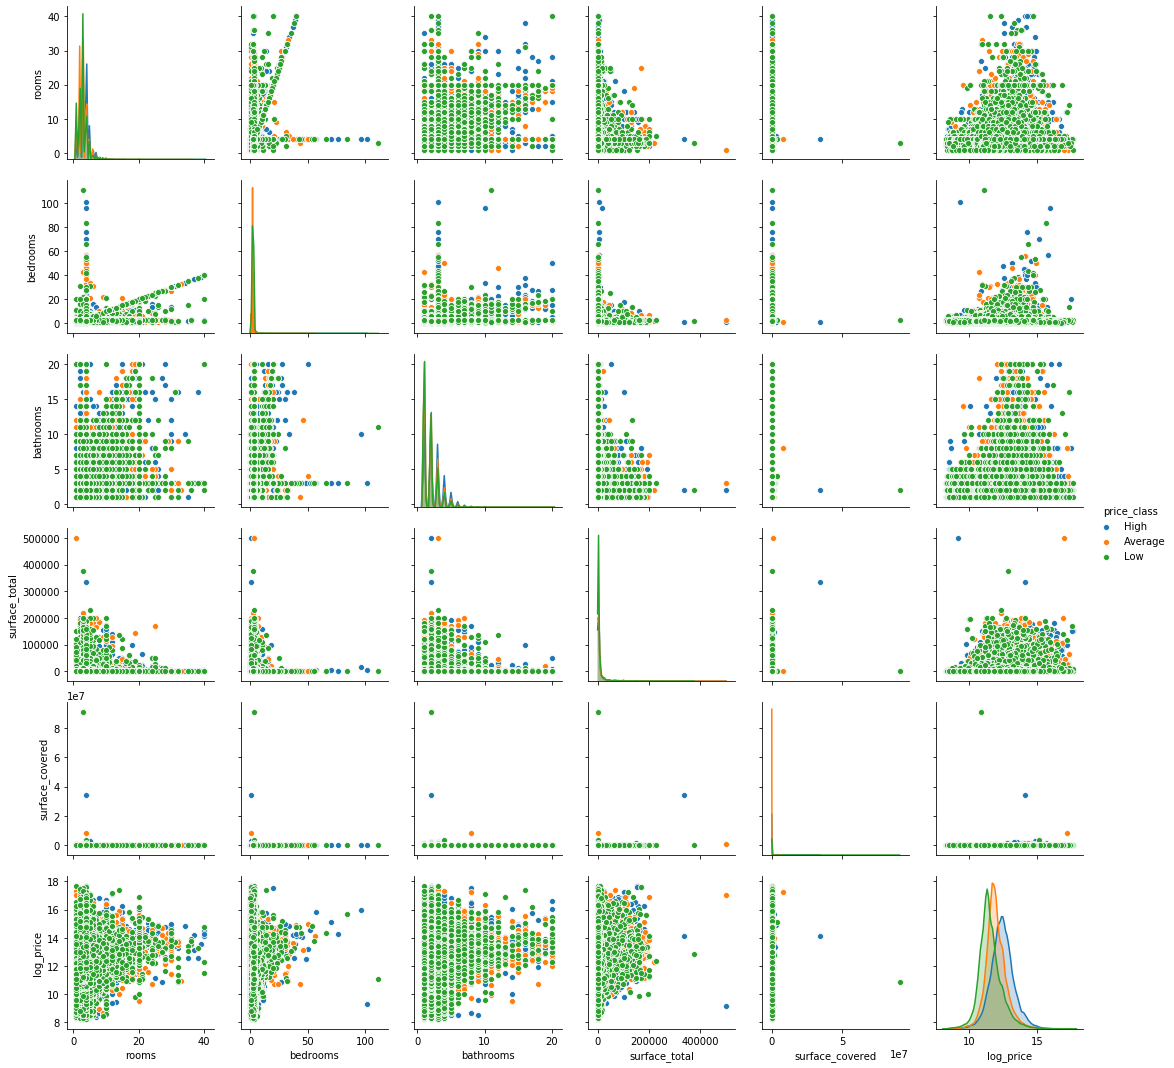

In [10]:
# Check variables correlations with df
features = ['rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered', 'log_price', 'price_class', 'l1', 'property_type']
sns.pairplot(df[features], hue = 'price_class')

In [10]:
# Remove OUTLIERS for use in PCA EXCLUDING PRICE VAR OF SOME SORT
# Define Function for removing outliers of numeric columns 
def remove_outlier(df):
    i = []
    low = .05
    high = .95
    cols = ['rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered'] #, 'log_price'
    quant_df = df[cols].quantile([low, high])
    
    for var in cols:
        df.loc[(df[var] < quant_df.loc[high, var]), 'keep'] = 1
        df.loc[(df[var] >= quant_df.loc[high, var]), 'keep'] = 0
        
        df = df[df.keep == 1]
        df = df.drop(columns = 'keep', inplace = False)
    return df

In [11]:
# df2 is the base dataset with outliers in the top 5% of an attributes value being removed
df2 = remove_outlier(df)
df2.reset_index(inplace = True)
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374434 entries, 0 to 374433
Data columns (total 21 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   index            374434 non-null  int64  
 1   lat              332875 non-null  float64
 2   lon              332875 non-null  float64
 3   rooms            374434 non-null  float64
 4   bedrooms         374434 non-null  float64
 5   bathrooms        374434 non-null  float64
 6   surface_total    374434 non-null  float64
 7   surface_covered  374434 non-null  float64
 8   price            374433 non-null  float64
 9   log_price        374434 non-null  float64
 10  id               374434 non-null  object 
 11  start_date       374433 non-null  object 
 12  end_date         374433 non-null  object 
 13  created_on       374433 non-null  object 
 14  property_type    374434 non-null  object 
 15  l1               374434 non-null  object 
 16  l2               374433 non-null  obje

In [12]:
# Create a new dataset that will contain our new price classification variable.
df_priceclass = df2.copy()
df_priceclass = df_priceclass.drop(columns = ['index', 'lat', 'lon', 'price', 'id', 'start_date', 'end_date', 'created_on',
                                             'l2', 'l3', 'title', 'description'])
df_priceclass.reset_index(inplace = True)

In [14]:
# Create the globaL categorized price attribute manually
price_class = []
low = .333
average = .666

quants = df_priceclass.log_price.quantile([low, average])
    
for obs in range(len(df_priceclass)):
    if df_priceclass.log_price[obs] <= quants.loc[low]:
        price_class.append('Low')
    elif df_priceclass.log_price[obs] >= quants.loc[average]:
        price_class.append('High')
    else:
        price_class.append('Average')

# Add the new column to the imputed dataframe
df_priceclass['price_class_overall'] = pd.DataFrame(price_class)
df_priceclass.drop(index = 374433, inplace = True)

In [15]:
# This is the base dataset that will be used for the Principal Component Analysis Clustering
df_priceclass.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 374433 entries, 0 to 374432
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   index                374433 non-null  int64  
 1   rooms                374433 non-null  float64
 2   bedrooms             374433 non-null  float64
 3   bathrooms            374433 non-null  float64
 4   surface_total        374433 non-null  float64
 5   surface_covered      374433 non-null  float64
 6   log_price            374433 non-null  float64
 7   property_type        374433 non-null  object 
 8   l1                   374433 non-null  object 
 9   price_class          374433 non-null  object 
 10  price_class_overall  374433 non-null  object 
dtypes: float64(6), int64(1), object(4)
memory usage: 34.3+ MB


# <font color = 'blue'>IV. Modeling and Evaluation 1
We will be looking at Geo Spatial Clustering, Agglomerative Clustering for property type = "Casa", and K-Means with PCA, DBScan.

## Geo Spatial Clustering
Clustering on a properties latitude and longitude may be helpful in imputing missing country, state, province, or locality information.  The imputation of these attributes is beneficial to our algorithms because the country, state, province, etc. variables provide information regarding the political and economic context of the property.  The country, or other political subdivisions, provide information about taxes, political priorities, economic development, and more.  Imputing these features using clustering is less accurate than comparing the property's coordinates to a database with this information, but in the absence of this information, the imputation is a fast and potentially very accurate workaround. We will explore the use of K-means clustering on latitude and longitude over a wide range of cluster values to determine the optimum parameters. 

In [15]:
# Import libraries for clustering
import scipy
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
from pylab import rcParams
import seaborn as sns

import sklearn
import sklearn.metrics as sm

In [79]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import time 

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import glob
from PIL import Image

import geopandas as gpd
from geopandas import GeoSeries
from shapely.geometry import Point

from sklearn.cluster import KMeans, MiniBatchKMeans

%matplotlib inline

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (12,8)
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

In [76]:
df = pd.read_csv(r'C:\\Users\\Tpeng\\OneDrive\\Documents\\SMU\\Term 3\\Machine Learning\\Lab1\\Imputed_Dataset.csv', sep = ',', header = 0)
df_lat_long = df[["lat", "lon"]]
df_lat_long = df_lat_long.dropna()

In [77]:
# Function was adapted from https://github.com/claudian37

def plot_geolocation_by_cluster(df, 
                                cluster=None, 
                                title=None, 
                                centers=None,
                                filename=None):
    '''
    Function to plot latitude and longitude coordinates
    #####################
    Args:
        df: pandas dataframe 
            Contains id, latitude, longitude, and color (optional).
        cluster: (optional) column (string) in df 
            Separate coordinates into different clusters
        title: (optional) string
        centers: (optional) array of coordinates for centers of each cluster
        filename: (optional) string  
    #####################
    Returns:
        Plot with lat/long coordinates 
    '''
    
    # Transform df into geodataframe
    geo_df = gpd.GeoDataFrame(df.drop(['lon', 'lat'], axis=1),
                           crs={'init': 'epsg:4326'},
                           geometry=[Point(xy) for xy in zip(df.lon, df.lat)])
    
    # Restrict to South America.
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    ax = world[world.continent == 'South America'].plot(figsize=(10, 10),
    color='white', edgecolor='black')
    
    # Plot
    geo_df.plot(ax=ax, alpha=0.4, zorder=1)
    
    # Plot coordinates from geo_df on top of NYC map
    if cluster is not None:
        
        geo_df.plot(ax=ax, column=cluster, alpha=0.5, 
                    cmap='viridis', linewidth=0.8, zorder=2)
        
        if centers is not None:
            centers_gseries = GeoSeries(map(Point, zip(centers[:,1], centers[:,0])))
            centers_gseries.plot(ax=ax, alpha=1, marker='X', color='red', markersize=100, zorder=3)
        
        plt.title(title)
        plt.xlabel('longitude')
        plt.ylabel('latitude')
        plt.show()
        
        if filename is not None:
            fig.savefig(f'{filename}', bbox_inches='tight', dpi=300)
    else:
        geo_df.plot(ax=ax, alpha=0.5, cmap='viridis', linewidth=0.8, legend=True, zorder=2)
        
        plt.title(title)
        plt.xlabel('longitude')
        plt.ylabel('latitude')
        plt.show()
        
    #fig.clf()

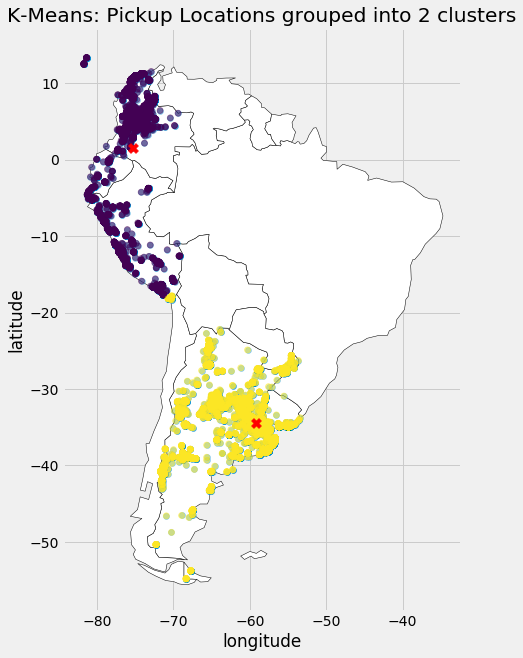

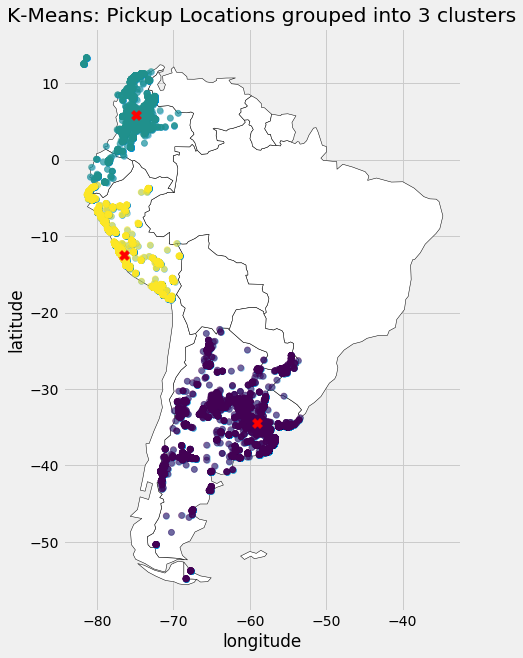

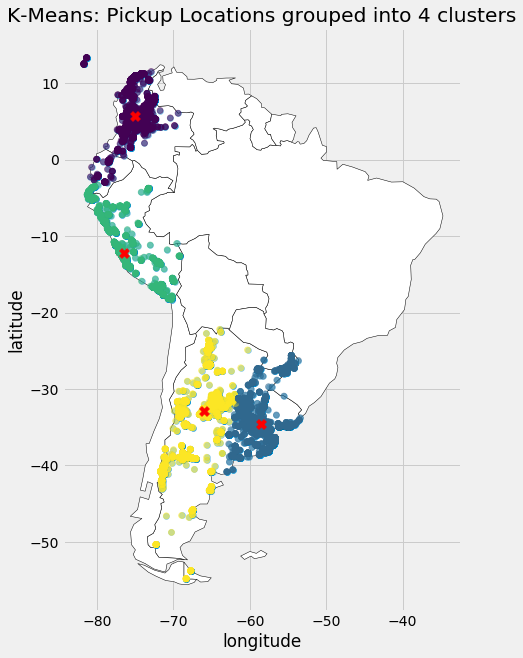

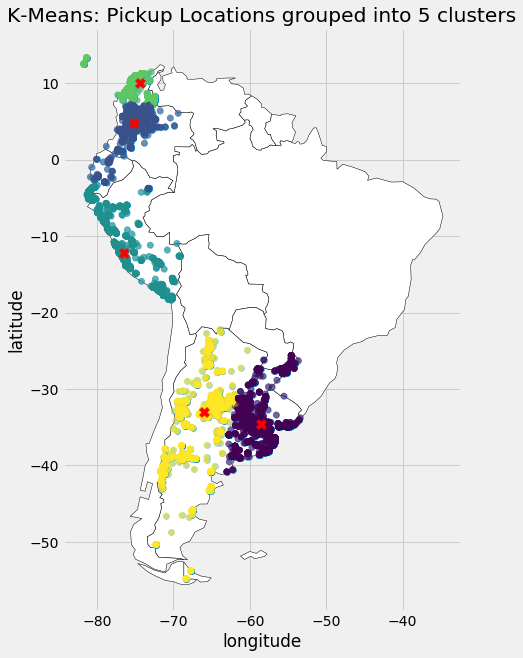

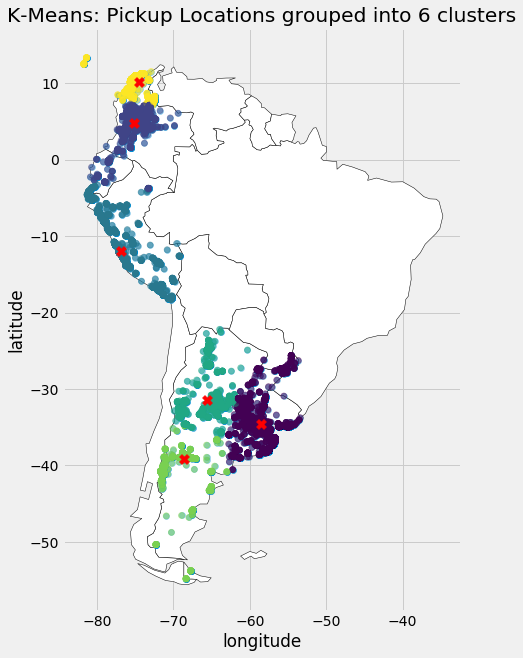

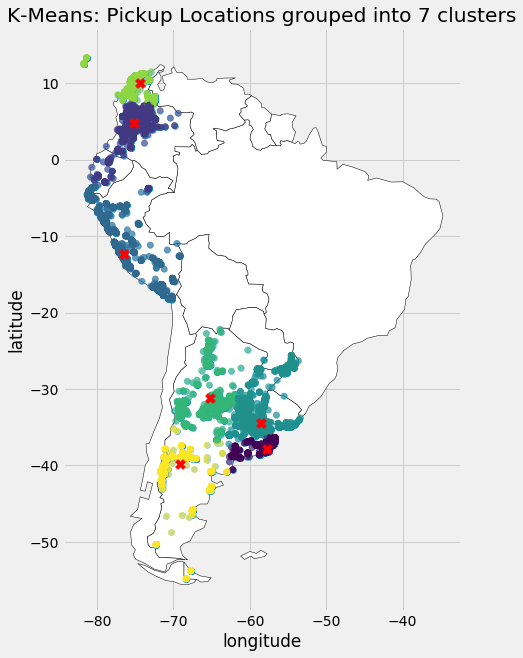

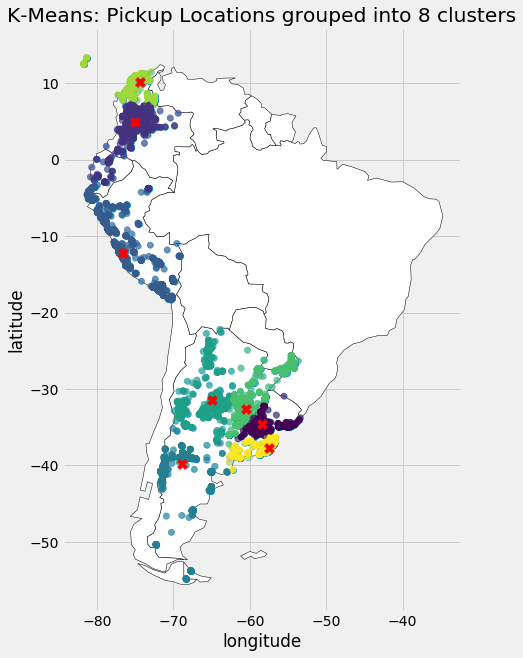

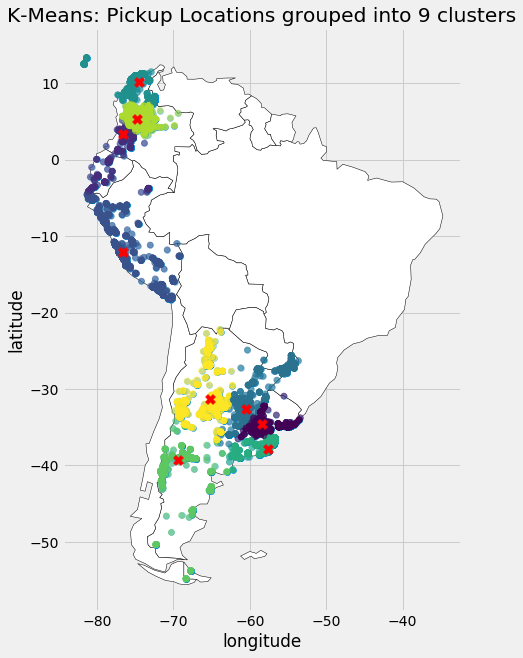

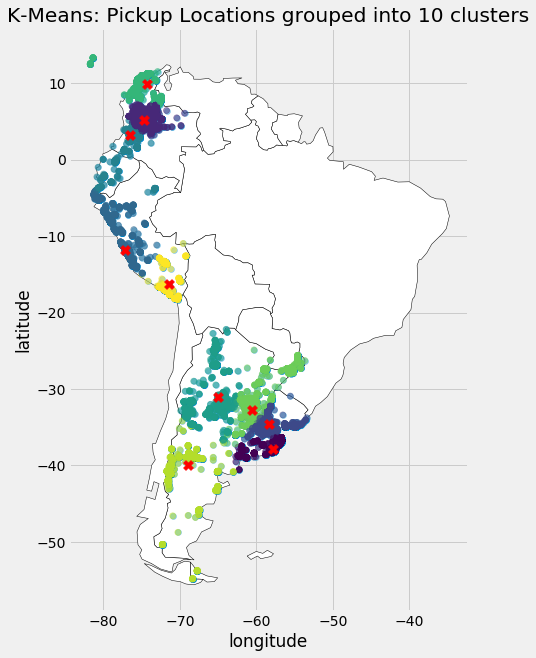

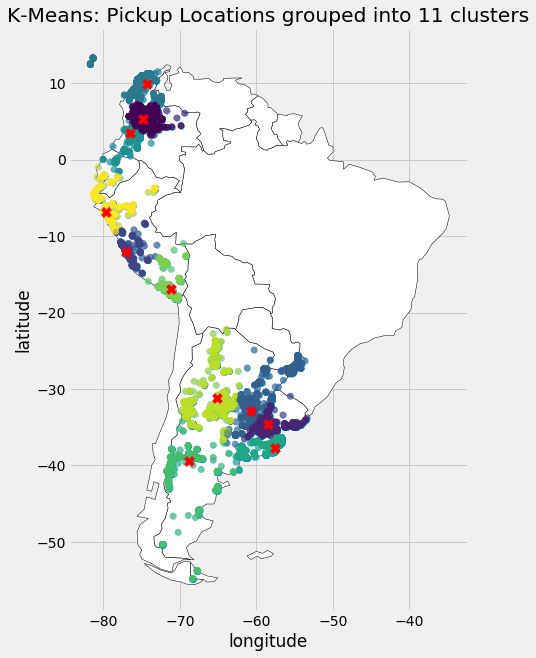

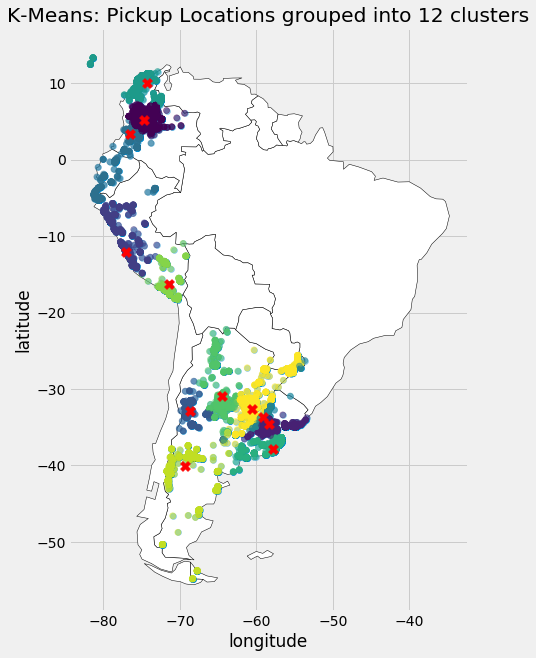

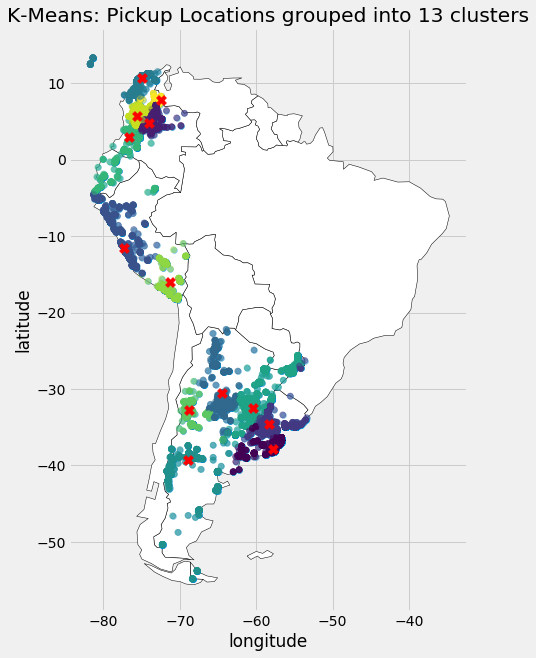

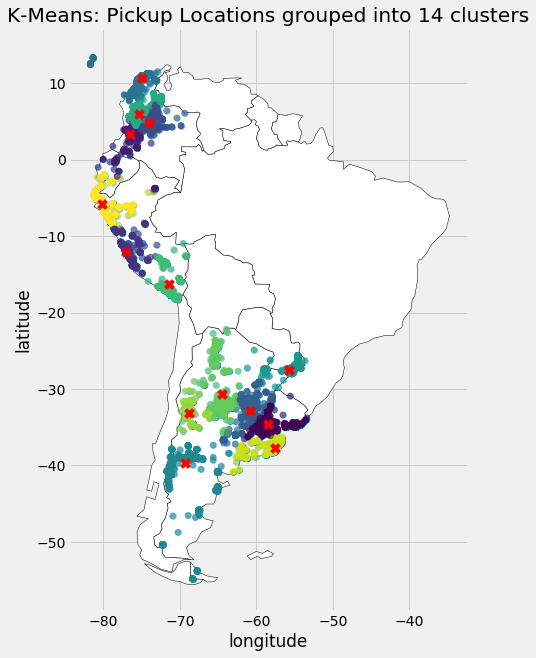

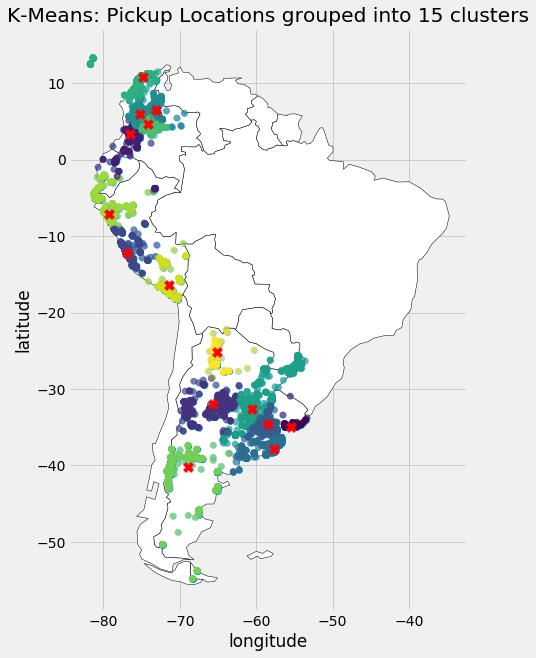

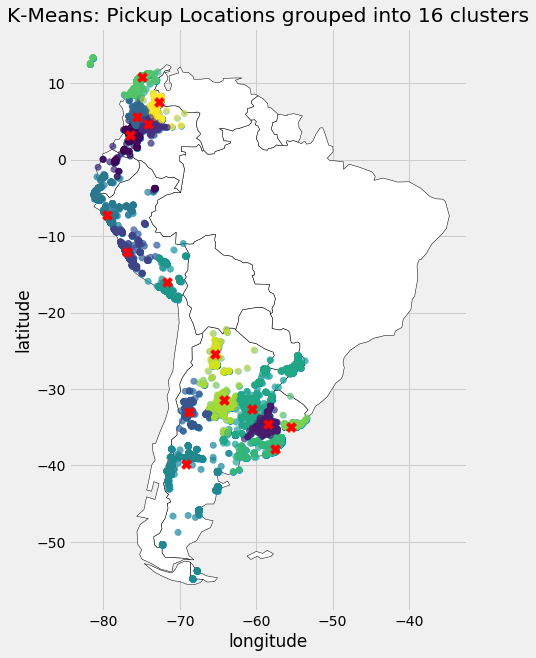

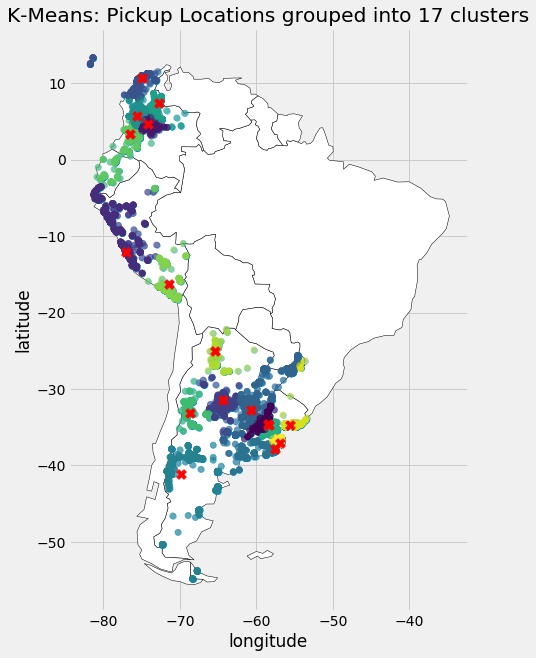

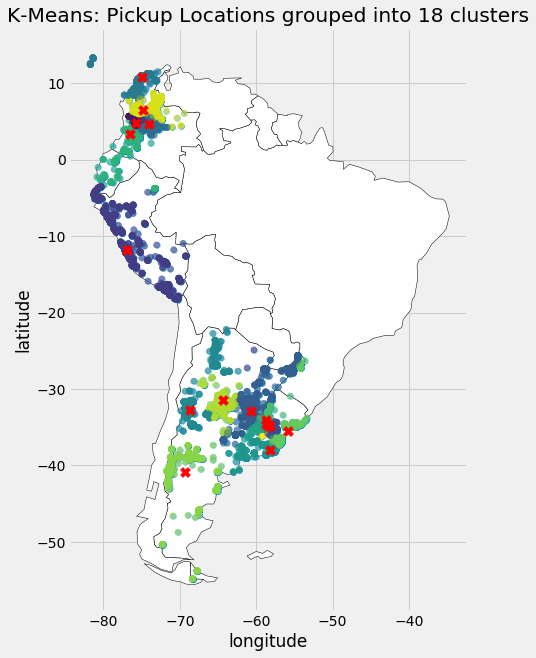

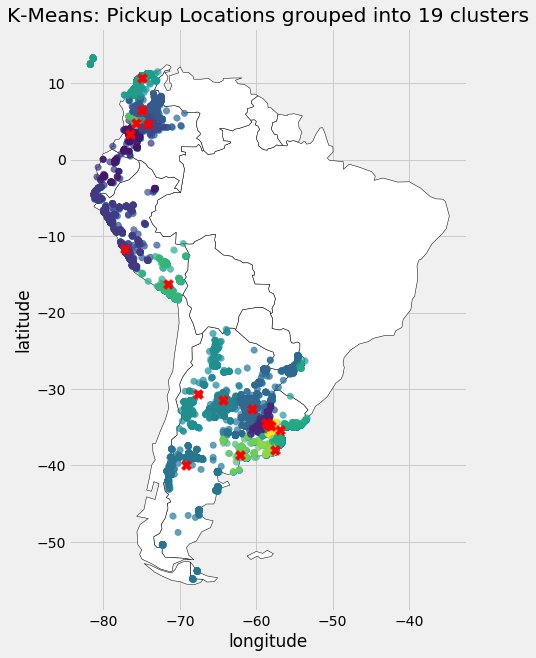

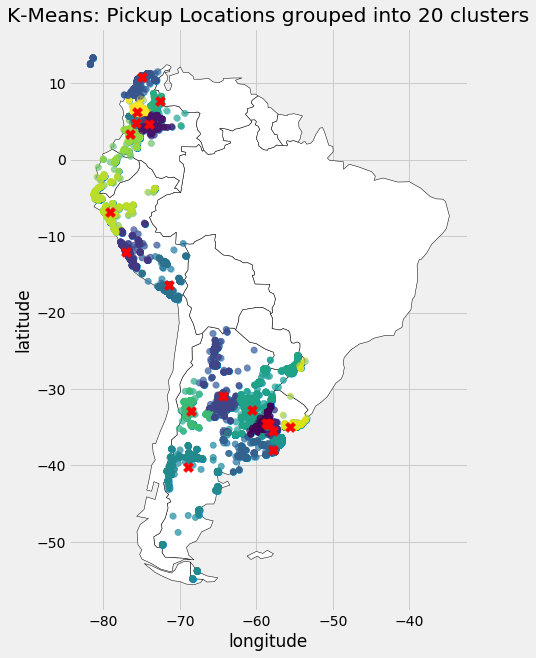

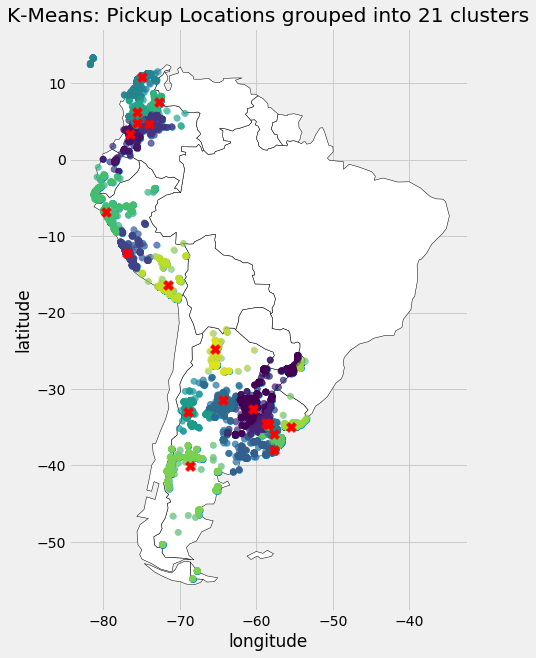

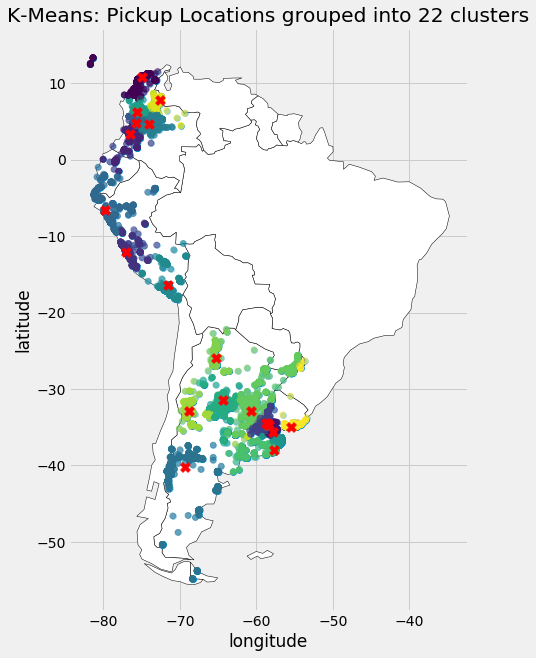

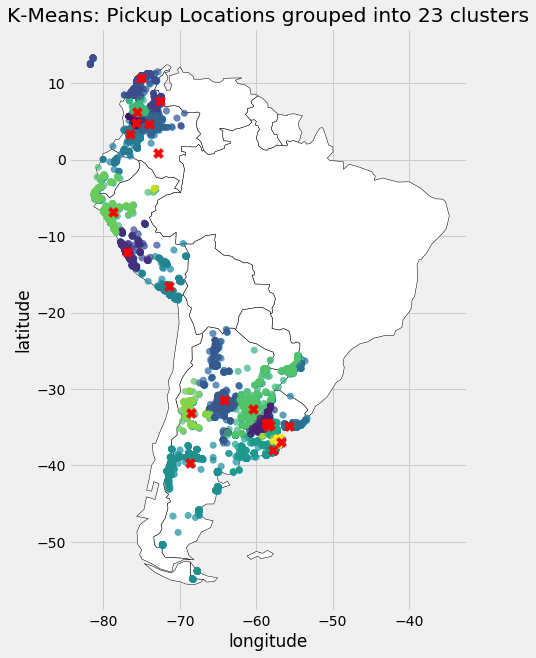

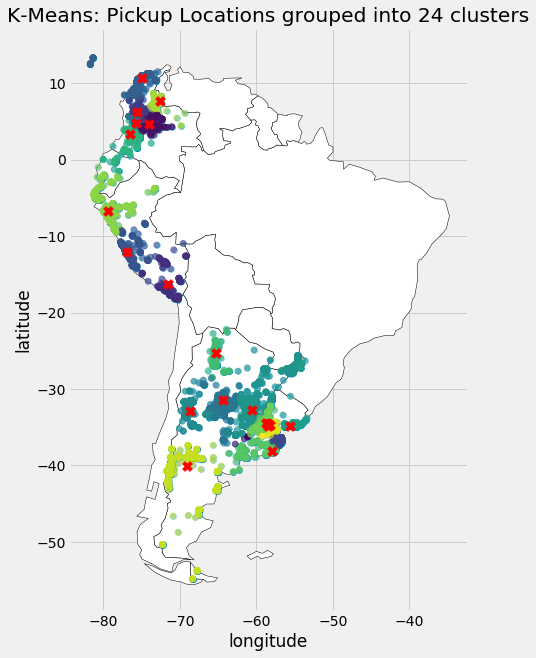

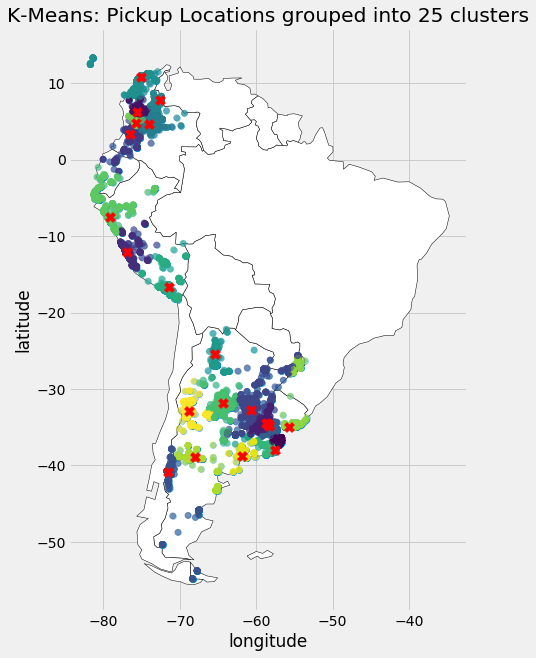

In [80]:
ssd = []

for i in range(2, 26):
    # Find clusters
    km = MiniBatchKMeans(n_clusters=i)
    km.fit_predict(df_lat_long)
    
    # Label cluster centers
    centers = km.cluster_centers_
    
    # Calculate sum of squared distances
    ssd.append(km.inertia_)
    
    # Get cluster center
    df_lat_long['cluster'] = km.labels_
    
    # Plot lat/long and clusters on map
    plot_geolocation_by_cluster(df_lat_long, cluster='cluster', 
                                title= f'K-Means: Pickup Locations grouped into {i} clusters',
                                centers=centers)

We will use the elbow method and the sum of squared distances to determine the optimum K parameter. In this case the elbow occurs at around 4-5 clusters, and this is likely the optimum number of clusters we would want when clustering to determine a property's country attribute. 

The clusters are fairly meaningless when there are a low number of clusters.  It is not until 4-5 clusters that we can interpret these clusters meaningfully. The clusters found when using 4 clusters are fairly useful; clusters capture a property's country with a decent degree of accuracy, with the exception that Colombia and Ecuador are combined in 1 cluster. When the number of clusters is increased to 5 to create a cluster for each nation, the algorithm splits Argentina into 2 clusters instead of separating Colombia and Ecuador. This is because Colombia and Ecaudor are closer together than the property clusters in North and South Argentina. As the number of clusters increase, their interpretation may begin to reflect more geographic features such as mountain ranges, large cities and their surroundings, and eventually they can predict department (state) level attributes. The centroids (red X's) for each cluster represent the geographical center of each property cluster. As the number of clusters increase, these centroids are more likely to be near large cities or other high population areas.

The optimum number of clusters would then depend on your use case for the clustering algorithm. For insights into smaller political subdivisions, a larger number of clusters is desired, while imputing missing country information would require a smaller number of clusters (and likely a different clustering algorithm).  


Text(0.5, 1.0, 'Elbow Method to Find Optimal Value of k')

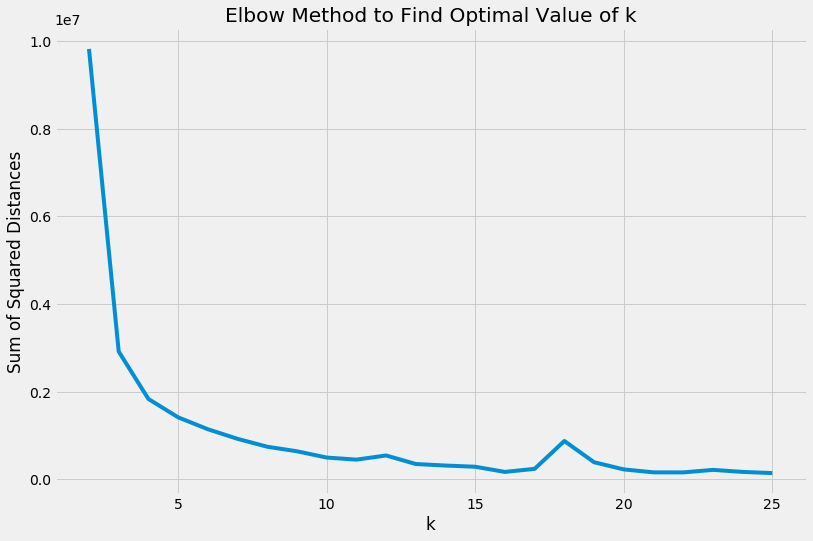

In [81]:
plt.plot(range(2,26), ssd)
plt.xlabel('k')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Method to Find Optimal Value of k')

## Agglomerative Clustering

Agglomerative Clustering was used to evaluate segmentation and property features within the “Casa” property type given country.  Since this is a bottom up approach with each data point starts out being its own cluster, initial modeling used all 463,716 rows of data yielded a MemoryError because the sample size, n, was too large.  Consequently, random sampling using a random seed = 6 was used to generate a subset of data with 30% of the original data, which was used for Agglomerative clustering. In addition, all numeric variables were scaled using MinMaxScaler (0,1) to eliminate individual feature having weight bias.  This is especially important since no outliers were removed from the data set.   Lastly, dummy variables for feature “l1”, or “country” were used.

Three Agglomerative clustering models were used with the following specifications:

n_cluster:  2,5, and 10

Affinity: Euclidean (default)

Connectivity: None (default)

Linkage: Ward (default)


In [16]:
#Plot the dataset: price vs. property_type
Casadf = df_num[(df_num.property_type == "Casa")]
Casadf = Casadf.drop(['property_type', 'log_price','price_class_final'],axis = 1)
Casadf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 131891 entries, 0 to 463716
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   rooms            131891 non-null  uint8  
 1   bedrooms         131891 non-null  uint8  
 2   bathrooms        131891 non-null  uint8  
 3   surface_total    131891 non-null  float64
 4   surface_covered  131891 non-null  float64
 5   price            131891 non-null  float64
 6   l1               131891 non-null  object 
dtypes: float64(3), object(1), uint8(3)
memory usage: 5.4+ MB


In [18]:
# Random Sampling of Data for Agglomerative Clustering 
dfAgg1 = Casadf.sample(frac = 0.3, random_state = 6)
dfAgg1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39567 entries, 345623 to 159492
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   rooms            39567 non-null  uint8  
 1   bedrooms         39567 non-null  uint8  
 2   bathrooms        39567 non-null  uint8  
 3   surface_total    39567 non-null  float64
 4   surface_covered  39567 non-null  float64
 5   price            39567 non-null  float64
 6   l1               39567 non-null  object 
dtypes: float64(3), object(1), uint8(3)
memory usage: 1.6+ MB


In [19]:
# Normalize Data Values along Features (columns)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
names = dfAgg1.columns
dfAgg1[['rooms','bedrooms','bathrooms', 'surface_total','surface_covered','price']] = scaler.fit_transform(dfAgg1[['rooms','bedrooms','bathrooms', 'surface_total','surface_covered','price']])
dfAgg1.head(5)

rooms  bedrooms  bathrooms  surface_total  surface_covered  \
345623  0.064516      0.06   0.157895       0.002588         0.000038   
374283  0.096774      0.08   0.157895       0.009588         0.000047   
219519  0.096774      0.08   0.157895       0.000965         0.000098   
187294  0.096774      0.08   0.052632       0.001404         0.000026   
445986  0.096774      0.06   0.210526       0.001864         0.000056   

           price         l1  
345623  0.001603   Colombia  
374283  0.007104   Colombia  
219519  0.016560  Argentina  
187294  0.007395  Argentina  
445986  0.027319       Perú

In [20]:
# Get Dummies Variables for Categorical Feature l1 (Country)
dfAgg2 = pd.get_dummies(data = dfAgg1, columns=['l1'])
dfAgg2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39567 entries, 345623 to 159492
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   rooms            39567 non-null  float64
 1   bedrooms         39567 non-null  float64
 2   bathrooms        39567 non-null  float64
 3   surface_total    39567 non-null  float64
 4   surface_covered  39567 non-null  float64
 5   price            39567 non-null  float64
 6   l1_Argentina     39567 non-null  uint8  
 7   l1_Colombia      39567 non-null  uint8  
 8   l1_Ecuador       39567 non-null  uint8  
 9   l1_Perú          39567 non-null  uint8  
 10  l1_Uruguay       39567 non-null  uint8  
dtypes: float64(6), uint8(5)
memory usage: 2.3 MB


In [21]:
# Convert pandas column of data to appropriate data types
dfAgg2['rooms'] = dfAgg2['rooms'].astype('int')
dfAgg2['bedrooms'] = dfAgg2['bedrooms'].astype('int')
dfAgg2['bathrooms'] = dfAgg2['bathrooms'].astype('int')
dfAgg2['surface_total'] = dfAgg2['surface_total'].astype('int')
dfAgg2['surface_covered']= dfAgg2['surface_covered'].astype('int')
dfAgg2['price'] = dfAgg2['price'].astype('int')
dfAgg2['l1_Argentina'] = dfAgg2['l1_Argentina'].astype('int')
dfAgg2['l1_Columbia'] = dfAgg2['l1_Colombia'].astype('int')
dfAgg2['l1_Ecuador'] = dfAgg2['l1_Ecuador'].astype('int')
dfAgg2['l1_Perú']= dfAgg2['l1_Perú'].astype('int')
dfAgg2['l1_Uruguay']=dfAgg2['l1_Uruguay'].astype('int')
dfAgg2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39567 entries, 345623 to 159492
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   rooms            39567 non-null  int32
 1   bedrooms         39567 non-null  int32
 2   bathrooms        39567 non-null  int32
 3   surface_total    39567 non-null  int32
 4   surface_covered  39567 non-null  int32
 5   price            39567 non-null  int32
 6   l1_Argentina     39567 non-null  int32
 7   l1_Colombia      39567 non-null  uint8
 8   l1_Ecuador       39567 non-null  int32
 9   l1_Perú          39567 non-null  int32
 10  l1_Uruguay       39567 non-null  int32
 11  l1_Columbia      39567 non-null  int32
dtypes: int32(11), uint8(1)
memory usage: 2.0 MB


In [22]:
#Import Library to Create Hierarchical Clustering
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

In [23]:
model1 = AgglomerativeClustering(n_clusters=2)
cluster1=model1.fit(dfAgg2)
cluster1_labels = cluster1.fit_predict(dfAgg2)
SScore1 = silhouette_score(dfAgg2,cluster1_labels, metric='euclidean')
SScore1

0.8914670731460869

In [24]:
model2 = AgglomerativeClustering(n_clusters=5)
cluster2=model2.fit(dfAgg2)
cluster2_labels = cluster2.fit_predict(dfAgg2)
SScore2 = silhouette_score(dfAgg2,cluster2_labels, metric='euclidean')
SScore2

0.9997289551408138

In [25]:
model3 = AgglomerativeClustering(n_clusters=10)
Cluster3_labels=model3.fit_predict(dfAgg2)
SScore3 = silhouette_score(dfAgg2,Cluster3_labels, metric='euclidean')
SScore3

0.9998810345292495

## Clustering on PCA Data

In [34]:
# Remove outliers and recast data for plotting
df_priceclass.drop(columns = 'index', inplace = True)
df_priceclass.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 374433 entries, 0 to 374432
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   rooms                374433 non-null  float64
 1   bedrooms             374433 non-null  float64
 2   bathrooms            374433 non-null  float64
 3   surface_total        374433 non-null  float64
 4   surface_covered      374433 non-null  float64
 5   log_price            374433 non-null  float64
 6   property_type        374433 non-null  object 
 7   l1                   374433 non-null  object 
 8   price_class          374433 non-null  object 
 9   price_class_overall  374433 non-null  object 
dtypes: float64(6), object(4)
memory usage: 31.4+ MB


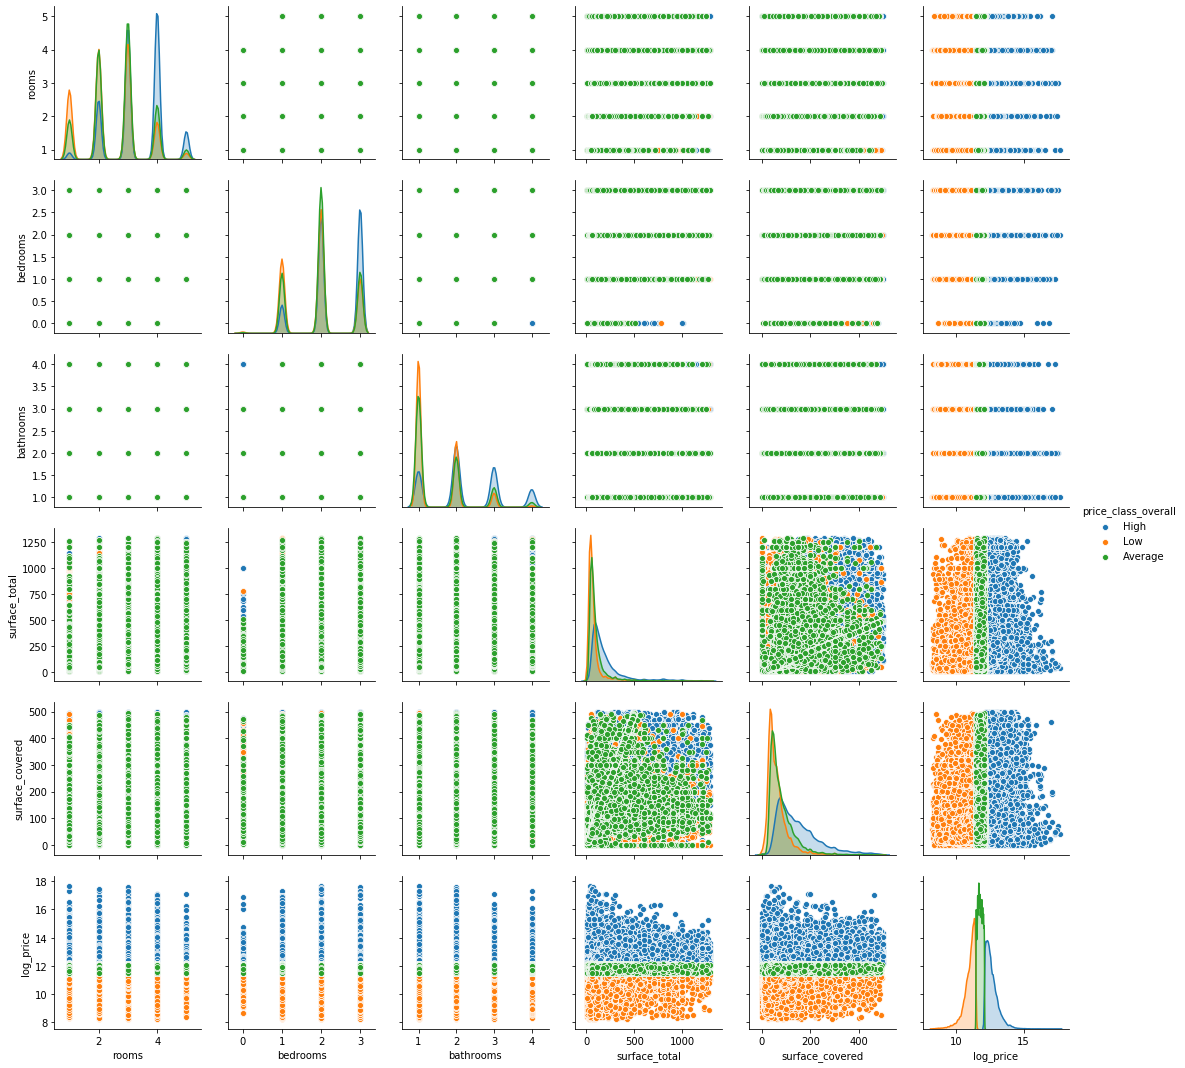

In [36]:
# Check variables correlations with df_priceclass
sns.pairplot(df_priceclass, hue = 'price_class_overall')

Looking at the scatterplot matrix above, we find that none of the numeric features provide useful information for clustering purposes. Visualizing these data by price class, country, property type, etc, all showed that these variables are not enough to meaningfully cluster on. We will address this by doing a Principal Component Analysis on this data to find more meaningful clusters.

# PCA 
Use PCA to cluster our data in the principal component space. We want to cluster over numeric variables and country, price classification, and property type to determine if clustering along these components can yield additional information about the real estate market in South America. 

Each attribute is scaled to between 0 and 1, and categorical variables are dummified to a value of 0 or 1 before PCA is conducted. This ensures that none of the features have a weight bias when comparing feature importances, and allows PCA component weights and feature importance to be more easily analyzed. 

In [37]:
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
cv_obj = KFold(n_splits = 10, shuffle = True, random_state = 6)
pca = PCA(n_components = 20, random_state = 6, svd_solver = 'full')

We will create dummy variables for country, property type, and global price classification for use in PCA, since it is thought that these variables are related to the property similarity.

In [38]:
# Dummify country vars 
pca_dummy = pd.get_dummies(df_priceclass, columns = ['l1', 'property_type', 'price_class_overall'], 
                          prefix = {'l1':'Country', 'property_type':'Property_Type', 'price_class_overall':'Price_Class_Overall'}, 
                          sparse = True, drop_first = False)

We normalize our numeric data and perform a principal component analysis. The first 4 principal components created explained between 15% and ~24% of the variance within our data, with the fifth component dropping off to ~5%. Thus our clustering would be best performed on at least 4 of the principal components

In [39]:
# Dummify country vars 
pca_dummy = pd.get_dummies(df_priceclass, columns = ['l1', 'property_type', 'price_class_overall'], 
                          prefix = {'l1':'Country', 'property_type':'Property_Type', 'price_class_overall':'Price_Class_Overall'}, 
                          sparse = True, drop_first = False)

C:\Users\Tpeng\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:509: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."


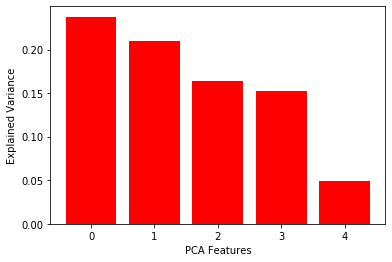

In [40]:
pca2 = PCA(n_components = 5, random_state = 6, svd_solver = 'full')
scaler = MinMaxScaler()
normalize = ['rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered']
reduced_df = pca_dummy.drop(columns = ['log_price','price_class'])

X_norm = pd.DataFrame(scaler.fit_transform(reduced_df[normalize]))
X_norm = pd.concat([X_norm, reduced_df.drop(columns = ['rooms', 'bedrooms', 'bathrooms', 'surface_total',
                                                      'surface_covered'], axis = 1)], axis = 1)

X_pca = pca2.fit_transform(X_norm)

features = range(pca2.n_components_)
plt.bar(features, pca2.explained_variance_ratio_, color = 'red')
plt.xlabel('PCA Features')
plt.ylabel('Explained Variance')
plt.xticks(features)

PCA_comps = pd.DataFrame(X_pca)

The visualization above shows the variance explained by each principal component. The first 4 components explain a moderate amount of variability (from 24% to 15%), with a significant drop off at the fifth principal component. We will limit our clustering algorithms to these 5 components.

In [41]:
# Determine which PCAs to keep
exp_var = pca2.explained_variance_ratio_.reshape(5,1)

In [ ]:
# Create a dataframe to better view components relationship to variables
Principal_Components = pd.DataFrame(columns = list(reduced_df.columns), data = pca2.components_)
Principal_Components.insert(loc = 0, column = 'PC', value = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])

# <font color ='blue'> V. Modeling and Evaluation 2: Evaluate and Compare

## Agglomerative Clustering

Agglomerative clustering algorithm took about 20 minutes to run with n_cluster = 10 and slightly less time (~15) for n_cluster = 5 and 2.  Silhouette scores for different n_clusters values are as listed in the table below.  With scores of 0.99973 for n_cluster =5 and 0.99988 for n_clusters = 10, there was no significant improvement of clustering performance beyond n_cluster = 5.   

Model 1      n_cluster = 2    Silhouette Score = 0.89147

Model 2      n_cluster = 5    Silhouette Score = 0.99973

Model 3      n_cluster = 10   Silhouette Score = 0.99988


# <font color = 'blue'>VI. Modeling and Evaluation 3: Visualizations of Results for Different Clustering Algorithms.

## Geospatial Clustering
Geospatial clustering visualizations were generated in the previous Section IV. Modeling and Evaluation as part of the modeling and training evaluation.  

## Agglomerative Clustering

The results of Agglomerative Clustering from the best model withn_clusters = 10 using normalized data are shown below with the original data features.  When the dataset is sliced to focus on a specific property type - "Casa", the following observations were made based on segmentation by country.  For example, Argentina seems to have higher pricing for "Casa" type properties than other countries; Colombia and Argentina have properties that contain more bedrooms; Uruguay and Ecuador properties tend to have fewer bathrooms, rooms, and surface_total compared to the same "Casa" property type in other countries.    

#Adding Cluster Labeling from model3 (n_cluster =10) to original dataset containing "Casa" property type only
dfAgg1['Cluster']= pd.Series(Cluster3_labels, index = dfAgg1.index)
dfAgg1.info()
dfAgg1.head(5)

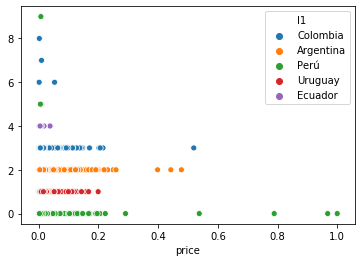

In [27]:
sns.scatterplot(dfAgg1.price,Cluster3_labels, hue=dfAgg1.l1)

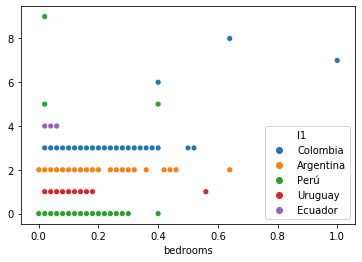

In [29]:
sns.scatterplot(dfAgg1.bedrooms,Cluster3_labels, hue=dfAgg1.l1)

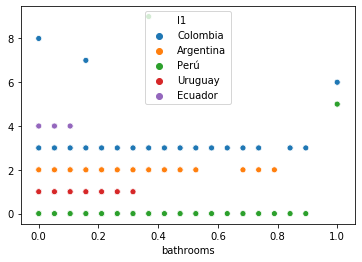

In [28]:
sns.scatterplot(dfAgg1.bathrooms,Cluster3_labels, hue=dfAgg1.l1)

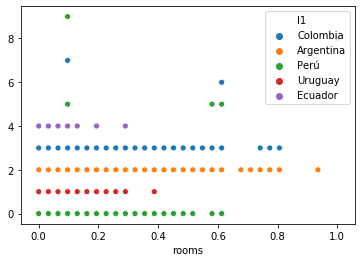

In [30]:
sns.scatterplot(dfAgg1.rooms,Cluster3_labels, hue=dfAgg1.l1)

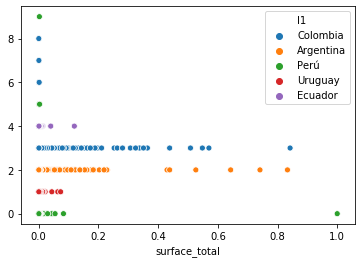

In [31]:
sns.scatterplot(dfAgg1.surface_total,Cluster3_labels, hue=dfAgg1.l1)

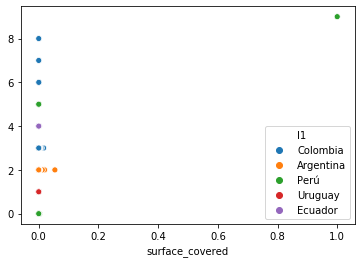

In [32]:
sns.scatterplot(dfAgg1.surface_covered,Cluster3_labels, hue=dfAgg1.l1)

## Principal Component Analysis for K-Means Clustering

In [43]:
# Visualize PCA Components while color coding for property type, price class, or country for easier interpretaion of Principal Components
PCA_viz = pd.concat([PCA_comps, df_priceclass.l1, df_priceclass.property_type, df_priceclass.price_class_overall], axis = 1)
PCA_viz.columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'l1', 'property_type', 'price_class_overall']
PCA_viz.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374433 entries, 0 to 374432
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   PC1                  374433 non-null  float64
 1   PC2                  374433 non-null  float64
 2   PC3                  374433 non-null  float64
 3   PC4                  374433 non-null  float64
 4   PC5                  374433 non-null  float64
 5   l1                   374433 non-null  object 
 6   property_type        374433 non-null  object 
 7   price_class_overall  374433 non-null  object 
dtypes: float64(5), object(3)
memory usage: 22.9+ MB


In [44]:
# Rename columns of dataframe
Principal_Components.columns = ['PC','rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered', 'Argentina', 'Colombia', 'Ecuador', 'Perú', 'Uruguay', 'Casa', 'Casa de campo',
 'Departamento', 'Depósito', 'Finca', 'Garaje', 'Local comercial', 'Lote', 'Oficina', 'Otro', 'PH', 'Parqueadero', 'Price_Class_Average', 'Price_Class_High', 'Price_Class_Low']

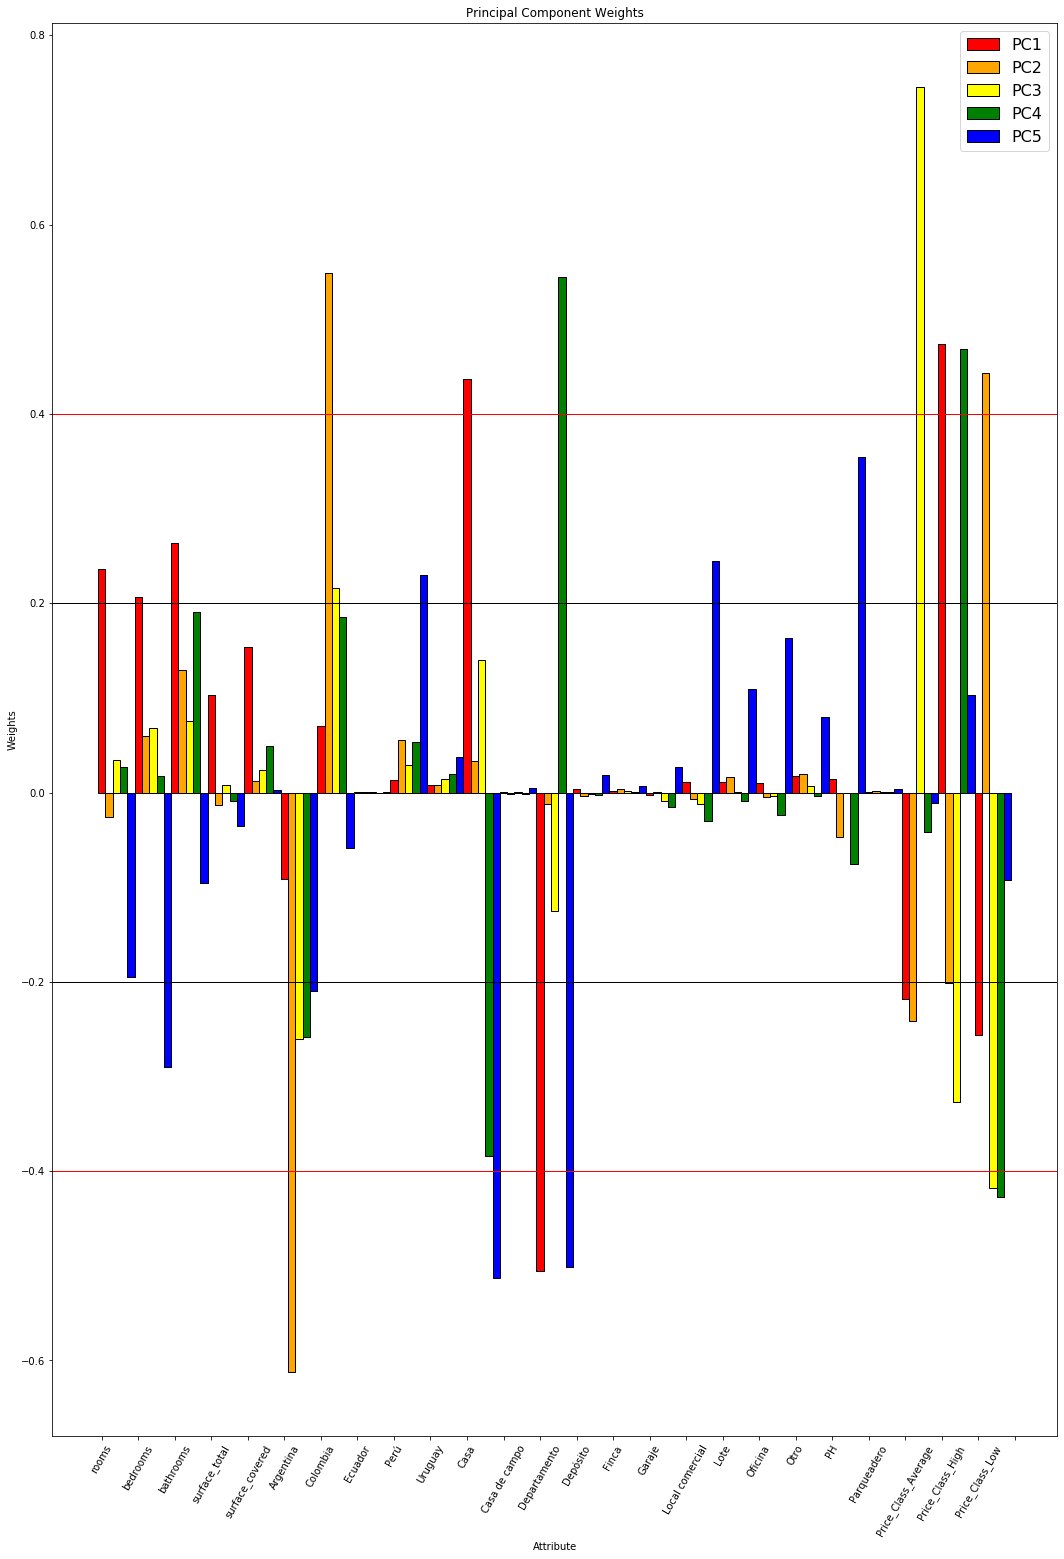

In [45]:
# Visualize PCA weights while weighting each PCA weight by the explained variance of the principal component.
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

# Initialize figure properties
plt.figure(figsize = (18,26))
barwidth = .2

# Create the bar plot data
pc1 = Principal_Components[Principal_Components.PC == 'PC1'][:1:].drop(columns = ['PC']).transpose()[0]
pc2 = Principal_Components[Principal_Components.PC == 'PC2'][:1:].drop(columns = ['PC']).transpose()[1]
pc3 = Principal_Components[Principal_Components.PC == 'PC3'][:1:].drop(columns = ['PC']).transpose()[2]
pc4 = Principal_Components[Principal_Components.PC == 'PC4'][:1:].drop(columns = ['PC']).transpose()[3]
pc5 = Principal_Components[Principal_Components.PC == 'PC5'][:1:].drop(columns = ['PC']).transpose()[4]

# Create bar locations
p1 = np.arange(len(pc1))
p2 = [x + barwidth for x in p1]
p3 = [x + 2*barwidth for x in p1]
p4 = [x + 3*barwidth for x in p1]
p5 = [x + 4*barwidth for x in p1]

# Plot Principal Components
plt.bar(p1, pc1, color = 'red', width = barwidth, edgecolor = 'black', label = 'PC1')
plt.bar(p2, pc2, color = 'orange', width = barwidth, edgecolor = 'black', label = 'PC2')
plt.bar(p3, pc3, color = 'yellow', width = barwidth, edgecolor = 'black', label = 'PC3')
plt.bar(p4, pc4, color = 'green', width = barwidth, edgecolor = 'black', label = 'PC4')
plt.bar(p5, pc5, color = 'blue', width = barwidth, edgecolor = 'black', label = 'PC5')

# Plot significance threshold lines
plt.axhline(y=.4, linewidth = 1, color = 'red')
plt.axhline(y=-.4, linewidth = 1, color = 'red')
plt.axhline(y=.2, linewidth = 1, color = 'black')
plt.axhline(y=-.2, linewidth = 1, color = 'black')

# Edit chart properties
plt.xlabel('Attribute')
plt.xticks(range(0,26), Principal_Components.drop(columns = 'PC').columns.tolist(), rotation = 60)
plt.ylabel('Weights')
plt.title('Principal Component Weights')

# Increase text size
plt.rcParams.update({'font.size':16})

plt.legend()
plt.show()

The bar plot above shows the raw weights for each attribute by principal component. Weights with a magnitude of 0.4 or greater could be considered impactful for our data (red horizontal line), and weights with a magnitude greater than 0.2 may also be somewhat impactful. 

Correlations between property attributes can be discerned from the plot above. For instance: Principal component 1 has a large positive correlation with a high price classification and property type casa, with significant positive correlations for the number of rooms, bathrooms, and bedrooms as well, while it does not have any country specific meaning. This indicates that houses with more room counts of all types tend to be classified as highly priced. This also indicates that house property types tend to have more rooms than other property types listed. It also contains a large negative correlation to the apartment property type, indicating that apartments tend to have fewer rooms counts, and also tend not to be considered highly priced.

Principal component 2 mostly deals with national differences. It is strongly positively correlated with a low price classification and the country Colombia, with a strong negative correlation for Argentina, and minor negative correlations for other price classifications. This indicates that Argentinian properties tend to not be classified as low priced, while Colombian properties are more associated with lower price classifications. 

PC3 is most strongly associated with an average price classification, and is also correlated with Colombia, and casa type properties, while being negatively correlated with apartments and Argentina. This indicates that properties in Colombia, and specifically houses, tend to be average priced, while apartments in Colombia, or other property types in Argentina tend not to be average priced.

PC4 is highly positively correlated with a high price classification and apartment property types, while being strongly negatively correlated with a low price classification and negatively correlated with casa property types and Argentina. This component further reinforces the differences between house and apartment property types and their price distinctions.

It is not until PC5 that the majority of property types can be incorporated. This component includes minor correlations with rooms and bedrooms as well as with the country Argentina and Peru. It also includes relatively large weights for houses, apartments, commercial shops, lots, offices, and horizontal property types (-0.5124, -0.50142, 0.245, 0.109, 0.1634, 0.354). There are insignificant weights given to price classifications in this component, which suggests that property type does not have a significant impact on property price once all other principal components have been taken into consideration. This component differentiates other property types from houses and apartments by giving negative weights to the numeric variables, indicating that other property types tend to have fewer room counts than casas.

While this plot describes the makeup of each principal component, it does not indicate the relative importance of each feature in the context of how much variance each component explains. To account for this, we will plot the PC weights while weighting each components' weights by the components' explained variance and normalizing with the sum of all weights. This will yield the proportion of variance that each attribute within a principal component explains, since each feature was scaled between 0 and 1.

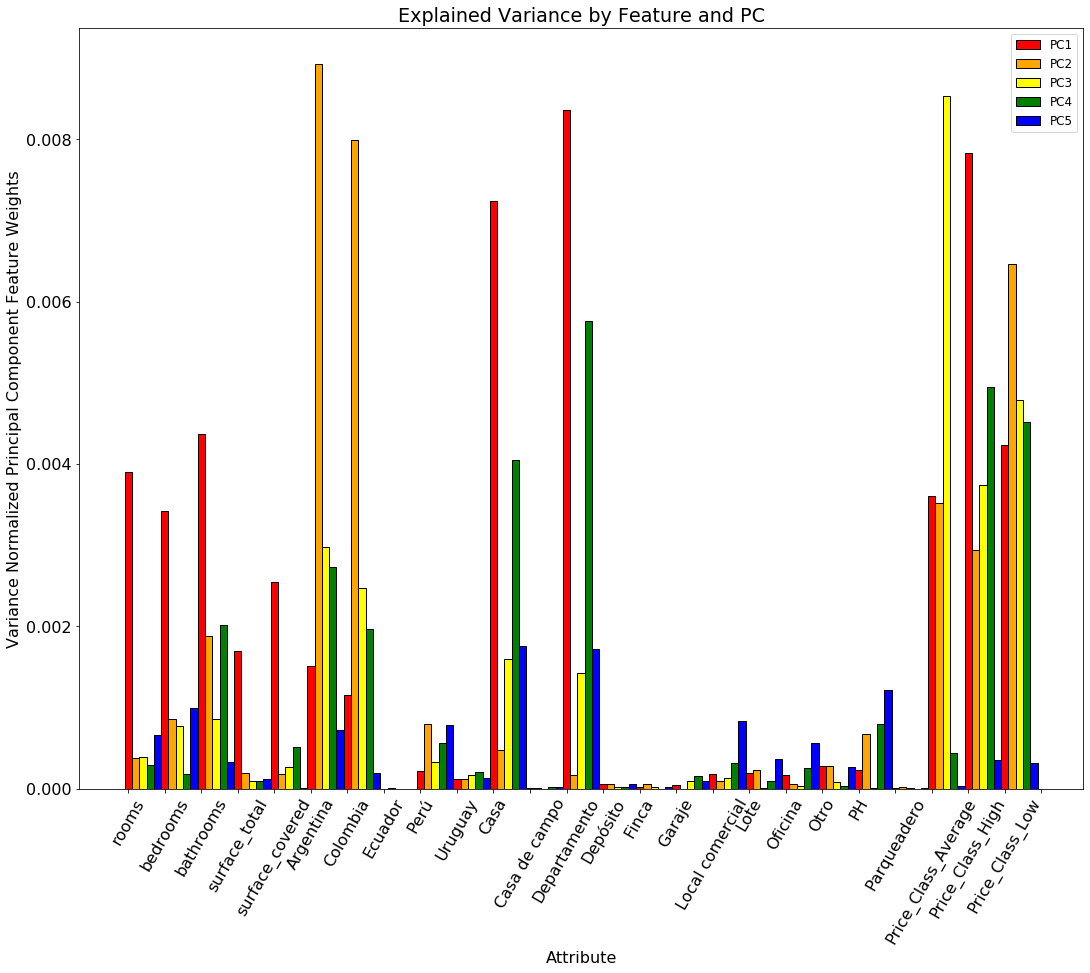

In [46]:
# Visualize PCA weights while weighting each PCA weight by the explained variance of the principal component and normalizing by the sum of weights ot get explained variance 
# per feature per principal component.
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

# Sum the weights for normalization
sum_weights = sum(abs(pc1)) + sum(abs(pc2)) + sum(abs(pc3)) + sum(abs(pc4)) + sum(abs(pc5))

# Initialize figure properties
plt.figure(figsize = (18,14))
barwidth = .2

# Create the bar plot data, 
pc1 = abs(Principal_Components[Principal_Components.PC == 'PC1'][:1:].drop(columns = ['PC']).transpose()[0]*pca2.explained_variance_ratio_[0]/sum_weights)
pc2 = abs(Principal_Components[Principal_Components.PC == 'PC2'][:1:].drop(columns = ['PC']).transpose()[1]*pca2.explained_variance_ratio_[1]/sum_weights)
pc3 = abs(Principal_Components[Principal_Components.PC == 'PC3'][:1:].drop(columns = ['PC']).transpose()[2]*pca2.explained_variance_ratio_[2]/sum_weights)
pc4 = abs(Principal_Components[Principal_Components.PC == 'PC4'][:1:].drop(columns = ['PC']).transpose()[3]*pca2.explained_variance_ratio_[3]/sum_weights)
pc5 = abs(Principal_Components[Principal_Components.PC == 'PC5'][:1:].drop(columns = ['PC']).transpose()[4]*pca2.explained_variance_ratio_[4]/sum_weights)

# Create bar locations
p1 = np.arange(len(pc1))
p2 = [x + barwidth for x in p1]
p3 = [x + 2*barwidth for x in p1]
p4 = [x + 3*barwidth for x in p1]
p5 = [x + 4*barwidth for x in p1]

# Plot Principal Components
plt.bar(p1, pc1, color = 'red', width = barwidth, edgecolor = 'black', label = 'PC1')
plt.bar(p2, pc2, color = 'orange', width = barwidth, edgecolor = 'black', label = 'PC2')
plt.bar(p3, pc3, color = 'yellow', width = barwidth, edgecolor = 'black', label = 'PC3')
plt.bar(p4, pc4, color = 'green', width = barwidth, edgecolor = 'black', label = 'PC4')
plt.bar(p5, pc5, color = 'blue', width = barwidth, edgecolor = 'black', label = 'PC5')

# Plot significance threshold lines
#plt.axhline(y=.03, linewidth = 1, color = 'red')
#plt.axhline(y=.001, linewidth = 1, color = 'black')

# Edit chart properties
plt.xlabel('Attribute')
plt.xticks(range(0,26), Principal_Components.drop(columns = 'PC').columns.tolist(), rotation = 60)
plt.ylabel('Variance Normalized Principal Component Feature Weights')
plt.title('Explained Variance by Feature and PC')

# Increase text size
plt.rcParams.update({'font.size':12})

plt.legend()
plt.show()

The above bar plot charts the weight each component gives to each attribute, while weighting each component by its explained variance in order to compare the relative importance of each component and their weights.  It should be noted that each principal component up to and including PC4 all have weights of a significant magnitude. This is expected since each of the first 4 principal components had relatively equal amounts of explained variance. 

## K-Means Clustering on PCA Data: Visualizations

# Clustering on PCA data
In this section we will explore multiple clustering algorithms to determine the most effective method.  Each clustering algorithm will be compared using the silhouette score.  The algorithms will be trained with a balanced subset of our dataset to improve computation time and to better represent each feature. We will undersample both apartment and housing property types such that their frequency is similar to the next largest property type (PH). We undersample each of these at 20,000 observations, reducing the number of observations in our data to ~ 97,000.

In [47]:
# We may need to balance the data when subsampling by using random undersampling of apartment and house property types
print(df_priceclass['property_type'].value_counts())
print(df_priceclass.count())

Departamento       231716
Casa                85319
PH                  18119
Local comercial     11554
Oficina              9580
Otro                 6576
Lote                 6231
Garaje               2151
Depósito             1688
Finca                 637
Casa de campo         578
Parqueadero           284
Name: property_type, dtype: int64
rooms                  374433
bedrooms               374433
bathrooms              374433
surface_total          374433
surface_covered        374433
log_price              374433
property_type          374433
l1                     374433
price_class            374433
price_class_overall    374433
dtype: int64


In [48]:
# Pick subsamples of property type departamento and casa that are roughly equal to the sample size of other property types
np.random.seed(6)
casa_ind = df_priceclass[df_priceclass.property_type == 'Casa'].index
casa_samp = np.random.choice(casa_ind, 20000, replace = False)

apt_ind = df_priceclass[df_priceclass.property_type == 'Departamento'].index
apt_samp = np.random.choice(apt_ind, 20000, replace = False)

other_ind = df_priceclass[(df_priceclass.property_type != 'Casa') & (df_priceclass.property_type != 'Departamento')].index

sample = np.concatenate((casa_samp, apt_samp, other_ind), axis =0)
X = PCA_comps.loc[sample]
y = df_priceclass.property_type.loc[sample]

In [49]:
# Begin with k-means ++ clustering using PCA_comps dataframe and grid search
from sklearn.cluster import KMeans
kmeans = KMeans(init = 'k-means++', verbose = 1, random_state = 6, n_jobs = 16)

Determining the number of clusters for K-means Clustering.

Here we run an initial loop testing a wide range of cluster numbers to determine which range we should focus on. We use the silhouette score to determine the optimum number of clusters: the model with the largest silhouette score will be used to cluster our data. The silhouette score was used since it is a relative measure of the similarity of observations within a cluster to their similarity to far-away clusters. We will also factor in cross-group clustering. Any clustering algorithm that contains cross-group clustering is undesirable for us, since these observations are known to be disimilar in reality (non Principal Component space).

# NOTE: This clusters on all 5 Principal Components.

In [ ]:
# Manual loop to cluster and calculate silhouette score
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

print(__doc__)

n_clusters = [5, 8, 10, 15, 20]

for n_cluster in n_clusters:
    # Create subplot
    fig, (ax1, ax2) = plt.subplots(1,2)
    fig.set_size_inches(16,10)
    
    # 1st subplot is silhouette plot which range from -1 to 1
    ax1.set_xlim([-.25,.25]) # was [-1, 1]
    ax1.set_ylim([0, len(X) + (n_cluster + 1) * 10])
    
    kmeans = KMeans(n_clusters = n_cluster, random_state = 6)
    cluster_labels = kmeans.fit_predict(X)
    
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("for n_clusters = ", n_cluster, ": The average silhouette score is:", silhouette_avg)
    
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

The clustering above suggests higher cluster counts, since the silhouette score increases as do the number of clusters. We will run again and visualize the outputs

In [ ]:
n_clusters = [20, 24, 28, 32, 36]

for n_cluster in n_clusters:
    
    kmeans = KMeans(n_clusters = n_cluster, random_state = 6)
    cluster_labels = kmeans.fit_predict(X)
    
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("for n_clusters = ", n_cluster, ": The average silhouette score is:", silhouette_avg)
    
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

The silhouette score begins dropping between 20-24 clusters. We will run the algorithm one more time to find the optimum number of clusters

In [ ]:
n_clusters = [18, 19, 20, 21, 22]

for n_cluster in n_clusters:
    
    kmeans = KMeans(n_clusters = n_cluster, random_state = 6)
    cluster_labels = kmeans.fit_predict(X)
    
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("for n_clusters = ", n_cluster, ": The average silhouette score is:", silhouette_avg)
    
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

for n_clusters =  18 : The average silhouette score is: 0.7091954672234012
for n_clusters =  19 : The average silhouette score is: 0.7129873749888378
for n_clusters =  20 : The average silhouette score is: 0.7132115536016574
for n_clusters =  21 : The average silhouette score is: 0.6780667802934455
for n_clusters =  22 : The average silhouette score is: 0.6425705392740897


The optimum number of clusters was found to be 20, with a silhouette score of 0.71321155. We will now visualize these clusters in the 3D principal component space.

In [50]:
# Cluster the data using 20 clusters
kmeans = KMeans(n_clusters = 20, random_state = 6, n_jobs = 16)
cluster_labels = kmeans.fit_predict(X)

C:\Users\Tpeng\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)


In [51]:
# Create a dataframe of original data with clusters added for visualization
# Not sure how well this visualization will work
df_viz = df_priceclass.loc[sample]
df_viz['Cluster'] = kmeans.labels_
cluster_centers = kmeans.cluster_centers_

In [56]:
# Create a dataframe with principal component data with l1, property type, price class overall and cluster added
pca_sample = PCA_comps.loc[sample]
pca_sample.columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5']
pca_sample['Cluster'] = kmeans.labels_
cluster_centers = kmeans.cluster_centers_

In [ ]:
# Visualize observations on principal component axes.
# This has numerics except prices, and l1 prop type in PCs
fig = px.scatter_3d(pca_sample, x = 'PC1', y = 'PC2', z = 'PC3', color = 'Cluster')
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

fig.show()

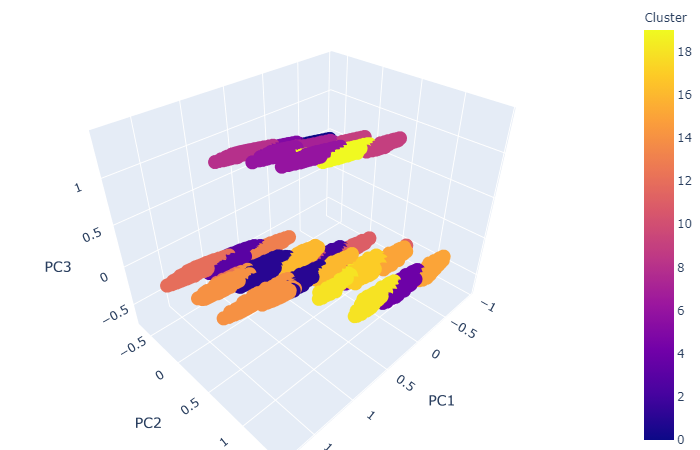

In [107]:
# The cell above generates an interactive 3D scatterplot that is far too large for the purpose of file sharing and submission. The image below is a view of the output.
from IPython.display import Image
Image(filename = 'KmeansClustering.PNG')

K-means clustering tends to cluster each visual grouping into 3 sub-clusters, with some cross-grouping exceptions.  These clusters tend to correspond to an observations property type and price. Visual groupings are broken up into 3 clusters along PC1, which represents property type. Observations with positive values tend to be casas, while those with negative values tend to be apartments, with middle values close to 0 representing all other property types. The groupings along PC3 also indicate price classification, with positive values tending to represent average price classications, and negative values representing either high or low price classifications depending on the observations PC2 value.

K-means does a fairly good job at clustering observations into property type-price classification sub-groups. Most clusters that cross visual-group boundaries do so along national lines (PC2), indicating that these clusters still hold true to property type and price classifications, even when they mis-cluster some observations.
<br><br>
However, K-means clustering does not perform well for this dataset as it is structured. There are many instances of clusters spreading between multiple visual groupings which is undesirable.  This is a result of the oblong shape of the visual clusters and their proximity to each other along principal components 1 and 2.  Another method would be better suited to this dataset. We will explore DBSCAN next, which is known to handle these types of clusters well.



## DBSCAN Clustering

The number of clusters to be used in the DBSCAN clustering algorithm will be determined by the hyperparameter values eps and min_samples that yield the highest silhouette score.  The clusterings produced by this algorithm must still make sense however. If the number of clusters produced by the highest silhouette score model can't easily be interpreted, then another model should be used.

In [ ]:
# This did not work because grid search requires CV, which I don't want for clustering
from sklearn.cluster import DBSCAN
db_cls = DBSCAN()
params = dict(db_cls__eps = [0.5, 0.9],
              db_cls__min_samples = [55],
              db_cls__metric = [silhouette_score(X, cluster_labels)],
              db_cls__algorithm = ['ball_tree'],
              db_cls__leaf_size = [50])

db_gs = GridSearchCV(db_cls, param_grid = params, scoring = silhouette_score(X, cluster_labels), n_jobs = 16, cv = 1)
%time db_gs.fit(X)

In [ ]:
# Grid Search CV requires cross validation. Try custom loops to run without cross validation
# Create variable ranges
eps = [0.001, 0.01, .1, .3, .5, 1, 3,]
min_samples = [5, 7, 15, 35, 55, 75, 100]
# metric = [silhouette_score(X, cluster_labels)]
algorithm = ['ball_tree']
leaf_size = [50, 70]

# Create vectors to store loop information
sil_score = []
i = 0

# Begin loop
for ep in eps:
    for min_samp in min_samples:
        for algo in algorithm:
            for leaf in leaf_size:
                print('Iteration: ', i)
                db_cls = DBSCAN(eps = ep, min_samples = min_samp, algorithm = algo, leaf_size = leaf, n_jobs = 16)
                print('Fit Time: ')
                %time db_cls.fit_predict(X)
                print('Score Time: ')
                %time sil_score.append(silhouette_score(X, db_cls.labels_))
                i = i + 1

Iteration:  0
Fit Time: 
Wall time: 1.73 s
Score Time: 
Wall time: 2min 19s
Iteration:  1
Fit Time: 
Wall time: 1.41 s
Score Time: 
Wall time: 2min 19s
Iteration:  2
Fit Time: 
Wall time: 1.48 s
Score Time: 
Wall time: 2min 19s
Iteration:  3
Fit Time: 
Wall time: 1.69 s
Score Time: 
Wall time: 2min 20s
Iteration:  4
Fit Time: 
Wall time: 1.37 s
Score Time: 
Wall time: 2min 20s
Iteration:  5
Fit Time: 
Wall time: 1.47 s
Score Time: 
Wall time: 2min 21s
Iteration:  6
Fit Time: 
Wall time: 1.41 s
Score Time: 
Wall time: 2min 23s
Iteration:  7
Fit Time: 
Wall time: 1.46 s
Score Time: 
Wall time: 2min 24s
Iteration:  8
Fit Time: 
Wall time: 1.43 s
Score Time: 
Wall time: 2min 24s
Iteration:  9
Fit Time: 
Wall time: 1.32 s
Score Time: 
Wall time: 2min 25s
Iteration:  10
Fit Time: 
Wall time: 1.49 s
Score Time: 
Wall time: 2min 27s
Iteration:  11
Fit Time: 
Wall time: 1.43 s
Score Time: 
Wall time: 2min 26s
Iteration:  12
Fit Time: 
Wall time: 1.41 s
Score Time: 
Wall time: 2min 28s
Iteration

ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

Iteration:  85
Fit Time: 
Wall time: 17min 9s
Score Time: 


ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

Iteration:  86
Fit Time: 
Wall time: 19min 55s
Score Time: 


ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

Iteration:  87
Fit Time: 
Wall time: 19min 36s
Score Time: 


ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

Iteration:  88
Fit Time: 
Wall time: 13min 51s
Score Time: 


ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

Iteration:  89
Fit Time: 
Wall time: 17min 31s
Score Time: 


ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

Iteration:  90
Fit Time: 
Wall time: 17min 9s
Score Time: 


ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

Iteration:  91
Fit Time: 
Wall time: 14min 46s
Score Time: 


ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

Iteration:  92
Fit Time: 
Wall time: 13min 45s
Score Time: 


ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

Iteration:  93
Fit Time: 
Wall time: 19min 8s
Score Time: 


ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

Iteration:  94
Fit Time: 
Wall time: 16min 2s
Score Time: 


ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

Iteration:  95
Fit Time: 
Wall time: 19min 5s
Score Time: 


ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

Iteration:  96
Fit Time: 
Wall time: 24min 43s
Score Time: 


ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

Iteration:  97
Fit Time: 
Wall time: 17min 24s
Score Time: 


ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

In [ ]:
# Get index for highest silhouette score
print(max(sil_score))
sil_score.index(max(sil_score))

0.7191628494159562


42

The maximum silhouette score of 0.719162849 occured at iteration 42, where eps = .3 and min samples = 100. We will run another DBSCAN using a range of values closer to these.

In [ ]:
# This is the 'full' DBSCAN to be run once the above works
# Create variable ranges
eps = [0.15, 0.175, 0.2, 0.225, 0.25, 0.275, .3, .325, .35, .375,]
min_samples = [5, 15, 35, 55, 75, 100]
# metric = [silhouette_score(X, cluster_labels)]
algorithm = ['ball_tree']
leaf_size = [30]

# Create vectors to store loop information
sil_score = []
i = 0

# Begin loop
for ep in eps:
    for min_samp in min_samples:
        for algo in algorithm:
            for leaf in leaf_size:
                print('Iteration: ', i)
                print('Eps: ', ep, '\nmin_samples: ', min_samp, '\nleaf_size: ', leaf)
                db_cls = DBSCAN(eps = ep, min_samples = min_samp, algorithm = algo, leaf_size = leaf, n_jobs = 16)
                print('Fit Time: ')
                %time db_cls.fit_predict(X)
                print('Score Time: ')
                %time sil_score.append(silhouette_score(X, db_cls.labels_))
                print('Silhouette Score: ', sil_score[i])
                i = i + 1

Iteration:  0
Eps:  0.15 
min_samples:  5 
leaf_size:  30
Fit Time: 
Wall time: 17.5 s
Score Time: 
Wall time: 2min 13s
Silhouette Score:  0.7070906796764205
Iteration:  1
Eps:  0.15 
min_samples:  15 
leaf_size:  30
Fit Time: 
Wall time: 15.3 s
Score Time: 
Wall time: 2min 13s
Silhouette Score:  0.7191206783180487
Iteration:  2
Eps:  0.15 
min_samples:  35 
leaf_size:  30
Fit Time: 
Wall time: 16.8 s
Score Time: 
Wall time: 2min 12s
Silhouette Score:  0.7187683950785496
Iteration:  3
Eps:  0.15 
min_samples:  55 
leaf_size:  30
Fit Time: 
Wall time: 16.4 s
Score Time: 
Wall time: 2min 12s
Silhouette Score:  0.7182634496781611
Iteration:  4
Eps:  0.15 
min_samples:  75 
leaf_size:  30
Fit Time: 
Wall time: 15.9 s
Score Time: 
Wall time: 2min 12s
Silhouette Score:  0.7173757608340474
Iteration:  5
Eps:  0.15 
min_samples:  100 
leaf_size:  30
Fit Time: 
Wall time: 17.7 s
Score Time: 
Wall time: 2min 12s
Silhouette Score:  0.7161701448716914
Iteration:  6
Eps:  0.175 
min_samples:  5 
le

In [ ]:
# Get index for highest silhouette score
print(max(sil_score))
sil_score.index(max(sil_score))

0.7191628494159562


6

There were multiple combinations of epsilon and min_samples that resulted in the maximum silhouette score of 0.7191628. These varied in fit and score times, and only one was slightly faster than the others. The optimum values were epsilon of 0.175, min_samples of 5, and a leaf size of 30, which resulted in a fit time of 19.8 seconds and a score time of 2:12. Now we will run the algorithm using the optimum values and plot the results on a 3D scatter plot along the principal component dimensions.

In [68]:
# Create the DBSCAN object with optimum hyperparameters
db_cls = DBSCAN(eps = .175, min_samples = 5, algorithm = 'ball_tree', leaf_size = 30, n_jobs = 16)
%time db_cls.fit_predict(X)
%time silhouette_score(X, db_cls.labels_)

Wall time: 11.2 s
Wall time: 2min 2s


0.7191628494159562

In [71]:
# Create a dataframe with principal component data with l1, property type, price class overall and cluster added
pca_sample_db = PCA_comps.loc[sample]
pca_sample_db.columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5']
pca_sample_db['Cluster'] = db_cls.labels_
core_samples = db_cls.components_

In [ ]:
# Visualize observations on principal component axes.
fig = px.scatter_3d(pca_sample_db, x = 'PC1', y = 'PC2', z = 'PC3', color = 'Cluster')
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

fig.show()

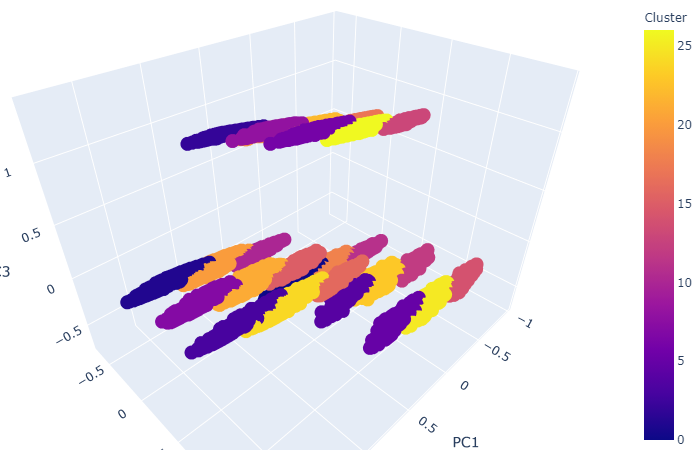

In [108]:
# The cell above generates an interactive 3D scatterplot that is far too large for the purpose of file sharing and submission. The image below is a view of the output.
Image(filename = 'DBSCANClustering.PNG')

The DBSCAN clustering method is much better than the k-means regarding cross grouping clusters. The silhouette score is only marginally better (0.71916 vs 0.71321), but there are no cross grouping clusters as in K-means. DBSCAN resulted in 27 clusters.  It is interesting that each visual grouping has 3 clusters within them. This is a result of our low epsilon value. If we increase the epsilon value to increase the size of our clusters, this will increase the tendency to include cross-grouping observations in a single cluster.  Most of the clusters are defined along PC1 and 3, with PC2 having a lot of overlap between clusters. Each of the 3 sub clusters within each group represent one of 3 property type groups: casa, apartment, and an aggregation of all other property types.

The lack of seperation between visual groupings along PC2 indicate that national differenes were not found to account for significant differences in the data, relative to other features. Each visual grouping is divided into 3 clusters along the first Principal component, indicating that most of the cluster differences are due to attributes captured in the first principal component. These sub-grouping clusters are defined by positive, 0, or negative values for PC1. Observations with positive values for PC1 tend to be houses with higher numbers of rooms, bathrooms, and bedrooms, while observations with negative values tend to have fewer room counts, and are more likely to be apartments, with middle, neutral values typically representing other property types. This is confirmed by the plot below. Aside from these sub-clusters and the information they provide, we also get price and some nationality information when looking at clusters along the third principal component, with observations of postive values near 1 indicating average price classifications, and observations with negative values indicating either low or high price classifications, depending on an observations PC2 values.  

When comparing clusters to property type divisions in the PCA space, it can be seen that each cluster in this arrangement mostly represents a property's type, with additional information about price, size, and nationality included.  Clusters centered near 0 on PC1 tend to be all property types that are not houses or apartments, indicating that these other property types have more in common with each other than they do with houses or apartments, which is expected given that they are more typically commercial in nature, rather than residential.  Cluster positioning along the 3rd principal component reflect pricing differences, with position along the 2nd principal component reflecting national differences combined with some pricing information. Thus these clusters indicated property type, price classification, national information, and housing size to some degree.

The DBSCAN is the better clustering algorithm to use for this purpose.  Each cluster truly represents a different type of property in more than just the property type sense. They also incorporate nationality, price, and size information as well. It should be noted that some clusters are more interpretable than others: those representing the aggregate of all property types are going to be more difficult to interpret than clusters representing casas or departamentos (house or apartments).

In [ ]:
# Visualize observations on principal component axes.
fig = px.scatter_3d(PCA_viz, x = 'PC1', y = 'PC2', z = 'PC3', color = 'property_type')
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

fig.show()

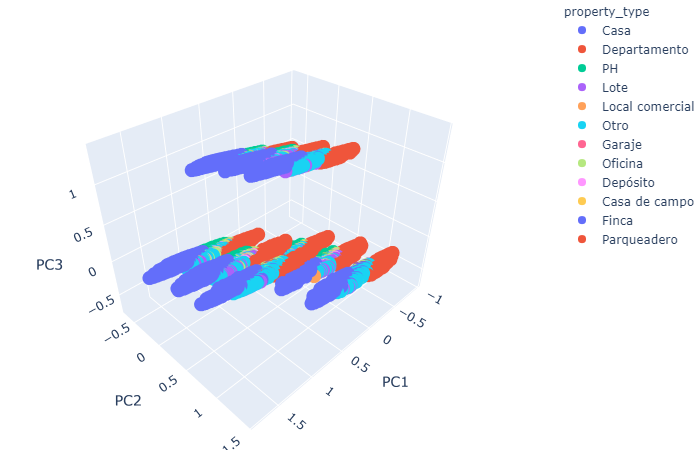

In [109]:
# The cell above generates an interactive 3D scatterplot that is far too large for the purpose of file sharing and submission. The image below is a view of the output.
Image(filename = 'proptype.PNG')

The plot above shows the observations plotted in the PCA space colored by property type. It can be seen that the groupings of property types are what are mostly captured by the clusterings produced by the DBSCAN algorithm.

# <font color = 'blue'>VII. Modeling and Evaluation 4: Summarization of Ramification
    
  Since our dataset can be clustered in many different slices, depending on the business goal and questions, we tried several different clustering methods, each has the potential to answer different business aspects. Geospatial clustering can provide insights based on generalizations about the potential desirability of property listings by location.  Similarly, DBScan clustering can reveal XXXXXX
Finally, agglomerative clustering yielded generalizations groups of features that may be more popular in certain countries over others.  
  An important take away is that large datasets may yield clusters that overlap, which may not be useful to the users.  Alternatively, it may be best to  segment the datasets before clustering to better yield meaningful attribute clusters.


# <font color = 'blue'>VIII.Deployment
Our data set is versatile and contained different factor levels within a specific feature where users can choose to slice and dice the data to help inform them on the real estate market in South America, depending on whether information on a general trend or specific trend is warranted. For that reason, we presented multiple clustering techniques that can be used for differnt business questions.  Regardless of the clustering algorithm used, it is a dynamic database where certain features don't require frequent updates such as (e.g. rooms, bedrooms, bathrooms, etc.) whereas other features may require more real time updates that can be done on a quarterly basis (e.g, price, price_class).  In addition, our models require a high degree of data preprocessing and quality checks for missing data and outliers before meaningful analyses can be ran.  Given the detailed maintenance required, a user subscription-based deployment would be ideal to keep our models accurate and user-friendly with various options to choose different levels of feature details. 
    
## Geospatial Clustering:
A relevant use of Geospatial clustering would be in planning for real estate investments such as vacation homes, theme parks, hotels, etc where proximity information on beaches, mountains, and other attractions may provide useful information. An enhancement to our model would be to add in "nearby" attractions to our data.  

## Agglomerative Clustering:
Our goal was to build a model that can drill down to a user-specified level of detail about property listings such as price by country, or inform the user on consumer preferences for different groupings of features, i.e. "Casa" property listings in Peru tend to have fewer bedrooms than those in Argentina and Columbia. Knowledge on consumer preference is an important factor in pricing and also in maintaining marketability of the property over time. The agglomerative cluster provided useful directionatl answers to this type of question and can serve as the basis for indepth analyses that can quantify the price multiples given specific sets of features and how pricing differs in different countries, reflectig consumer preference. Improvements to the model would include the exclusion of outliers, which normalization did not take care of and can be seen from the clustering visualizations.  In addition, the model may be enhanced with the ability to change property types, or drill down into one country/region by combining results for geospatial clustering.

## DBScan Clustering on PCA Analysis: 
There are some shortfalls with this model that needs to be addressed to improve the models usefulness. This is namely, that there is too small a sample of observations for 'other' property types (any property type that isn't house (casa) or apartment (departamento)). The result is that this model is very good at distinguishing houses and apartments, but all other property types cannot be distinguished from each other.

Third parties may use this model to determine what "type" of property an asset is before it is listed based on its given information.  Tags could be associated with each of these clusters or sub-clusters, which can automatically be generated when a listing is created. These tags can describe more than just the property type, but also its price (or quality), size, and location which can be used to automatically display similar properties to customers who are browsing listings. 

This particular model would be best deployed on the website backend, automatically tagging properties based on their attributes and comparing them to those of similar properties.  These tags would then be used to direct targeted ads or property listings to customers who are browsing for specific property types.

This algorithm could be improved with the incorporation of additional data. Features like GDP per capita, population, distances to businesses or landmarks, more property type-specific information (number of offices for office buildings, number and size of barns for farms, etc) could further distinguish between the types of a property type (i.e. a big office building compared to a very small one, which is currently not distinguished given our data), or could help distinguish the "other" property types that are aggregated into a single cluster by our algorithm. In addition to this, more examples of other property types such as offices, lots, farms, garages, camps, and warehouses would improve the algorithms ability to differentiate these types of property's from each other, which the current model can not do very well.

This model wouldn't need to be updated very frequently, since the tags would likely remain valid over the course of time. Updating the model should be done proportionally to market activity and most importantly economic development. As these nations develop more, the tags and property structures derived from past data will not be as relevant. Updating the model on a quarterly to 6-monthly cycle would likely be more than enough to keep the model up to date.

# <font color = 'blue'>IX.  Exceptional Work




Below, we will incorporate the cluster numbers into our dataset and use this data to train a price classification algorithm. The random forest classifier will be used, since this had the highest accuracy in our previous lab (~93%). The dataset will include rooms, bedrooms, bathrooms, surface_total, surface_covered, log_price, property type, country, and cluster to classify the price_class attribute. We will use the reduced dataset which undersamples casa and departamento.

The random forest classifier used will be the exact (best) one used for the last lab, with all hyperparameters remaining unchanged.  The resulting classifications were roughly half as accurate as the original model excluding cluster numbers. This drop in performance is likely due to a combination of variable correlations (the cluster numbers are very correlated with property type, price classification, etc...) and the introduction of a new variable without running a grid search to find the new optimum hyperparameter values.  It is possible that, once a gridsearchCV has been run, this new data could be just as accurate or more accurate than the previous model.

In [103]:
X = df_priceclass.loc[sample]
X.log_price = X.log_price.astype(np.float64)
X['price'] = np.exp(X.log_price)
X['Cluster'] = pca_sample_db.Cluster

X = pd.get_dummies(X, columns = ['l1', 'property_type', 'Cluster'], 
                          prefix = {'l1':'Country', 'property_type':'Property_Type', 'Cluster':'Cluster'}, 
                          sparse = True, drop_first = True)

y = X.price_class.values
X = X.drop(columns = ['price_class_overall', 'price_class']).values
X

array([[3., 1., 1., ..., 0., 0., 0.],
       [4., 3., 2., ..., 0., 0., 0.],
       [3., 3., 3., ..., 0., 0., 0.],
       ...,
       [1., 2., 1., ..., 0., 0., 0.],
       [1., 2., 1., ..., 0., 0., 0.],
       [4., 2., 2., ..., 0., 0., 0.]])

In [104]:
# Must use GridSearchCV on final model to get fit times and performance metrics
from sklearn.ensemble import RandomForestClassifier
clf_pipe = Pipeline([('Scaler', MinMaxScaler(copy = False)),
                     ('CLF', RandomForestClassifier(n_jobs = -1))])

params = dict(CLF__criterion = ['gini'],
              CLF__max_features = [.35],
              CLF__min_samples_leaf = [2],
              CLF__min_samples_split = [16],
              CLF__n_estimators = [100])

grid = GridSearchCV(clf_pipe, param_grid = params, cv = 5, n_jobs = -1, verbose = 2, scoring = 'accuracy')

%time grid.fit(X,y)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    8.2s remaining:   12.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.2s finished


Wall time: 10.9 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Scaler', MinMaxScaler(copy=False)),
                                       ('CLF',
                                        RandomForestClassifier(n_jobs=-1))]),
             n_jobs=-1,
             param_grid={'CLF__criterion': ['gini'],
                         'CLF__max_features': [0.35],
                         'CLF__min_samples_leaf': [2],
                         'CLF__min_samples_split': [16],
                         'CLF__n_estimators': [100]},
             scoring='accuracy', verbose=2)

In [105]:
grid.cv_results_

{'mean_fit_time': array([7.12000079]),
 'std_fit_time': array([0.03684186]),
 'mean_score_time': array([0.15163183]),
 'std_score_time': array([0.00496625]),
 'param_CLF__criterion': masked_array(data=['gini'],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_CLF__max_features': masked_array(data=[0.35],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_CLF__min_samples_leaf': masked_array(data=[2],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_CLF__min_samples_split': masked_array(data=[16],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_CLF__n_estimators': masked_array(data=[100],
              mask=[False],
        fill_value='?',
             dtype=object),
 'params': [{'CLF__criterion': 'gini',
   'CLF__max_features': 0.35,
   'CLF__min_samples_leaf': 2,
   'CLF__min_samples_split': 16,
   'CLF__n_estimators': 100}],
 'spli

# Clustering on PCA data for more significant cluster meanings and easier interpretations.